In [1]:
# Ensemble Variant 1: S: Densenet201, W: ResNet152d (Batch_size = 16, With ShapCAM)
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import torch
import torch.nn as nn
import sys
sys.path.extend(["..", "../../backbone","../.."])
from ctran import CTranEncoder
from densenet201 import DenseNet201
from resnet152d import ResNet152d
from dataloader import create_dataloader
from metric import Metric
from cam_generate import ShapCAMGenerator
from sklearn.metrics import roc_curve, auc, precision_recall_curve, roc_auc_score, f1_score
import torch.nn.functional as F
from torchvision import transforms
from tqdm import tqdm
from tabulate import tabulate
torch.cuda.empty_cache()
# from torchsummary import summary

# Set device to GPU if available, else use CPU
device = torch.device("cuda")
print(f"Current device: {torch.cuda.get_device_name(torch.cuda.current_device())}" if torch.cuda.is_available() else "Current device: CPU")

Current device: NVIDIA RTX A6000


In [2]:
# Define hyperparameters
batch_size = 16
num_epochs = 120
learning_rate = 0.000001
image_size = 320
num_workers = 6
num_layers = 12
embed_dim = 960
num_labels = 20
thresholds = [0.5] * num_labels
num_classes = 20
data_dir = '../../../mured-data/data'

In [3]:
# Create dataloaders
train_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='train')
val_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='val')

320
320


In [4]:
# Define model and optimizer
backbone1 = ResNet152d(num_classes=num_classes, embed_dim = embed_dim)
model1 = CTranEncoder(num_classes=num_classes, image_size=image_size, embed_dim=embed_dim, num_layers=num_layers, num_heads=num_workers, backbone=backbone1)
model1.to(device)

# Define model and optimizer
backbone2 = DenseNet201(num_classes=num_classes, embed_dim = embed_dim)
model2 = CTranEncoder(num_classes=num_classes, image_size=image_size, embed_dim=embed_dim, num_layers=num_layers, num_heads=num_workers, backbone=backbone2)
model2.to(device)

# Wrap your model with DataParallel
# model1 = nn.DataParallel(model1, device_ids=[0, 1, 2, 3])
# model2 = nn.DataParallel(model2, device_ids=[0, 1, 2, 3])

criterion = nn.BCEWithLogitsLoss()

# Define your optimizers
# Combine the parameters of both models
params = list(model1.parameters()) + list(model2.parameters())

# Create a single optimizer
optimizer = torch.optim.AdamW(params, lr=5e-5, weight_decay=1e-6)

# Create a single scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, epochs= num_epochs, steps_per_epoch=len(train_dataloader))

/home/deependra/project/rfmidc/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/deependra/project/rfmidc/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# Initialize Metric class
metric1 = Metric(num_classes=num_classes)
metric2 = Metric(num_classes=num_classes)

# create empty lists to store predicted probabilities and true labels for each epoch
val_preds_all, val_labels_all = [], []

# define the epochs at which to plot the ROC curve
roc_epochs = [5,10,20,30,40,50,60,70,80,90,100,120,140,160,180,200]

# create empty lists to store ROC data for each epoch
roc_fpr = []
roc_tpr = []
roc_auc = []
f1_arr = []
loss_arr = []
model_arr = []
max_ms = [0,0,0]
a,b = 0.4,0.6

# Train and evaluate model
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print('-' * 10)

    # Train phase
    model1.train()
    model2.train()
    for images, labels in tqdm(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs1 = model1(images)
        loss1 = criterion(outputs1, labels) 
        outputs1 = torch.sigmoid(outputs1)
           
    
        # Forward pass for model2
        outputs2 = model2(images)
        loss2 = criterion(outputs2, labels)
        outputs2 = torch.sigmoid(outputs2)
         
        
        # Calculate weighted average loss
        loss = a * loss1 + b * loss2
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute metrics on train set
        with torch.no_grad():
            metric1.update(outputs1, labels,0)
            
        with torch.no_grad():
            metric2.update(outputs2, labels,0)
    
    # Print metrics on train set 1
    ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score = metric2.compute(1)
    print("DenseNet201:\n",f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
    
    # Print metrics on train set 2
    ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score = metric1.compute(1)
    print("ResNet152d:\n",f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
    
    # Reset Metric class for evaluation
    metric1.reset()
    metric2.reset()
    del images
    del labels
    del outputs1
    del outputs2
    torch.cuda.empty_cache() 

    # Evaluate model on validation set
    model1.eval()
    model2.eval()
    running_loss = 0.0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(val_dataloader):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs1 = model1(images)
            loss1 = criterion(outputs1, labels) 
            outputs1 = torch.sigmoid(outputs1)
               
    
            # Forward pass for model2
            outputs2 = model2(images)
            loss2 = criterion(outputs2, labels) 
            outputs2 = torch.sigmoid(outputs2)
            
        
            # Calculate weighted average loss
            loss = a * loss1 + b * loss2
            running_loss += loss.item()
            
            # Perform weighted average of model predictions
            weighted_outputs = a * outputs1 + b * outputs2

            # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
            val_preds += weighted_outputs.tolist()
            val_labels += labels.tolist()
            metric1.update(weighted_outputs, labels,1)

 
        # Print metrics on validation set
        ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score = metric1.compute(0)
        print(f"Val - Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
        
        f1_arr.append(ml_f1_score)
        model_arr.append(model_score)
        loss_arr.append(running_loss / len(val_dataloader))
        
        if max_ms[0] < model_score: 
            max_ms[0] = model_score
            max_ms[1] = epoch
            max_ms[2] = optimizer.param_groups[0]['lr']

        # append the predicted probabilities and true labels for this epoch to the lists for all epochs
        val_preds_all.append(val_preds)
        val_labels_all.append(val_labels)

        # check if the current epoch is in the list of epochs to plot ROC curve
        if epoch+1 in roc_epochs:
            # calculate ROC curve and AUC score for validation set
            fpr, tpr, roc_thresholds = roc_curve(np.concatenate(val_labels_all).ravel(), np.concatenate(val_preds_all).ravel())
            roc_fpr.append(fpr)
            roc_tpr.append(tpr)
            roc_auc.append(auc(fpr, tpr))

        print() # empty line for spacing    
        
        # Reset Metric class for next epoch
        metric1.reset()
        del images
        del labels
        del outputs1
        del outputs2
        torch.cuda.empty_cache()   
    
    # Step the learning rate scheduler
    scheduler.step()     

Epoch 1/120
----------


100%|██████████| 111/111 [00:58<00:00,  1.91it/s]


DenseNet201:
 Epoch [1/120], Loss: 0.3357, ML mAP: 0.1142, ML F1: 0.0129, ML AUC: 0.6119, ML Score: 0.3630, Bin AUC: 0.1579, Model Score: 0.2605, Bin F1: 0.0000
ResNet152d:
 Epoch [1/120], Loss: 0.3357, ML mAP: 0.0792, ML F1: 0.0078, ML AUC: 0.4892, ML Score: 0.2842, Bin AUC: 1.0000, Model Score: 0.6421, Bin F1: 0.1333


100%|██████████| 28/28 [00:05<00:00,  5.02it/s]


Val - Epoch [1/120], Loss: 0.2760, ML mAP: 0.1842, ML F1: 0.0000, ML AUC: 0.7714, ML Score: 0.4778, Bin AUC: 0.6316, Model Score: 0.5547, Bin F1: 0.0000

Epoch 2/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.94it/s]


DenseNet201:
 Epoch [2/120], Loss: 0.2832, ML mAP: 0.1688, ML F1: 0.0124, ML AUC: 0.7285, ML Score: 0.4487, Bin AUC: 0.9474, Model Score: 0.6980, Bin F1: 0.0000
ResNet152d:
 Epoch [2/120], Loss: 0.2832, ML mAP: 0.0783, ML F1: 0.0000, ML AUC: 0.4894, ML Score: 0.2839, Bin AUC: 0.8947, Model Score: 0.5893, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  5.07it/s]


Val - Epoch [2/120], Loss: 0.2409, ML mAP: 0.1597, ML F1: 0.0000, ML AUC: 0.7862, ML Score: 0.4730, Bin AUC: 0.2105, Model Score: 0.3417, Bin F1: 0.0000

Epoch 3/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.92it/s]


DenseNet201:
 Epoch [3/120], Loss: 0.2727, ML mAP: 0.1845, ML F1: 0.0074, ML AUC: 0.7565, ML Score: 0.4705, Bin AUC: 0.8039, Model Score: 0.6372, Bin F1: 0.0000
ResNet152d:
 Epoch [3/120], Loss: 0.2727, ML mAP: 0.0772, ML F1: 0.0000, ML AUC: 0.4821, ML Score: 0.2796, Bin AUC: 0.7843, Model Score: 0.5320, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  5.08it/s]


Val - Epoch [3/120], Loss: 0.2333, ML mAP: 0.1865, ML F1: 0.0000, ML AUC: 0.8058, ML Score: 0.4961, Bin AUC: 0.6842, Model Score: 0.5902, Bin F1: 0.0000

Epoch 4/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [4/120], Loss: 0.2261, ML mAP: 0.2164, ML F1: 0.0238, ML AUC: 0.7849, ML Score: 0.5006, Bin AUC: 0.8421, Model Score: 0.6714, Bin F1: 0.0000
ResNet152d:
 Epoch [4/120], Loss: 0.2261, ML mAP: 0.0941, ML F1: 0.0000, ML AUC: 0.5201, ML Score: 0.3071, Bin AUC: 0.7368, Model Score: 0.5220, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  5.08it/s]


Val - Epoch [4/120], Loss: 0.2474, ML mAP: 0.1872, ML F1: 0.0000, ML AUC: 0.7972, ML Score: 0.4922, Bin AUC: 0.7368, Model Score: 0.6145, Bin F1: 0.0000

Epoch 5/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [5/120], Loss: 0.2371, ML mAP: 0.2464, ML F1: 0.0372, ML AUC: 0.7993, ML Score: 0.5229, Bin AUC: 0.6719, Model Score: 0.5974, Bin F1: 0.0000
ResNet152d:
 Epoch [5/120], Loss: 0.2371, ML mAP: 0.1392, ML F1: 0.0083, ML AUC: 0.6259, ML Score: 0.3825, Bin AUC: 0.5625, Model Score: 0.4725, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  5.02it/s]


Val - Epoch [5/120], Loss: 0.2398, ML mAP: 0.2744, ML F1: 0.0000, ML AUC: 0.8425, ML Score: 0.5585, Bin AUC: 0.1579, Model Score: 0.3582, Bin F1: 0.0000

Epoch 6/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [6/120], Loss: 0.2019, ML mAP: 0.2924, ML F1: 0.1047, ML AUC: 0.8267, ML Score: 0.5595, Bin AUC: 0.6944, Model Score: 0.6270, Bin F1: 0.0000
ResNet152d:
 Epoch [6/120], Loss: 0.2019, ML mAP: 0.1313, ML F1: 0.0119, ML AUC: 0.6231, ML Score: 0.3772, Bin AUC: 0.6667, Model Score: 0.5219, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  5.08it/s]


Val - Epoch [6/120], Loss: 0.2177, ML mAP: 0.2711, ML F1: 0.0404, ML AUC: 0.8417, ML Score: 0.5564, Bin AUC: 0.8421, Model Score: 0.6993, Bin F1: 0.0000

Epoch 7/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [7/120], Loss: 0.2263, ML mAP: 0.3579, ML F1: 0.1633, ML AUC: 0.8588, ML Score: 0.6084, Bin AUC: 0.8421, Model Score: 0.7252, Bin F1: 0.0000
ResNet152d:
 Epoch [7/120], Loss: 0.2263, ML mAP: 0.1371, ML F1: 0.0006, ML AUC: 0.6420, ML Score: 0.3896, Bin AUC: 0.6842, Model Score: 0.5369, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  5.17it/s]


Val - Epoch [7/120], Loss: 0.2072, ML mAP: 0.3390, ML F1: 0.0718, ML AUC: 0.8705, ML Score: 0.6048, Bin AUC: 0.8947, Model Score: 0.7498, Bin F1: 0.0000

Epoch 8/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [8/120], Loss: 0.3036, ML mAP: 0.4200, ML F1: 0.2192, ML AUC: 0.8765, ML Score: 0.6482, Bin AUC: 0.8947, Model Score: 0.7715, Bin F1: 0.0000
ResNet152d:
 Epoch [8/120], Loss: 0.3036, ML mAP: 0.1376, ML F1: 0.0000, ML AUC: 0.6566, ML Score: 0.3971, Bin AUC: 0.6842, Model Score: 0.5407, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  5.17it/s]


Val - Epoch [8/120], Loss: 0.2104, ML mAP: 0.3711, ML F1: 0.0745, ML AUC: 0.8770, ML Score: 0.6240, Bin AUC: 0.7895, Model Score: 0.7067, Bin F1: 0.0000

Epoch 9/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [9/120], Loss: 0.2056, ML mAP: 0.4723, ML F1: 0.2654, ML AUC: 0.8886, ML Score: 0.6804, Bin AUC: 0.4737, Model Score: 0.5771, Bin F1: 0.0000
ResNet152d:
 Epoch [9/120], Loss: 0.2056, ML mAP: 0.1432, ML F1: 0.0000, ML AUC: 0.6519, ML Score: 0.3975, Bin AUC: 0.8421, Model Score: 0.6198, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  4.95it/s]


Val - Epoch [9/120], Loss: 0.2242, ML mAP: 0.4283, ML F1: 0.0815, ML AUC: 0.8819, ML Score: 0.6551, Bin AUC: 0.8421, Model Score: 0.7486, Bin F1: 0.0000

Epoch 10/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.92it/s]


DenseNet201:
 Epoch [10/120], Loss: 0.1903, ML mAP: 0.4867, ML F1: 0.2925, ML AUC: 0.8994, ML Score: 0.6930, Bin AUC: 0.8611, Model Score: 0.7771, Bin F1: 0.0000
ResNet152d:
 Epoch [10/120], Loss: 0.1903, ML mAP: 0.1470, ML F1: 0.0000, ML AUC: 0.6630, ML Score: 0.4050, Bin AUC: 1.0000, Model Score: 0.7025, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  5.11it/s]


Val - Epoch [10/120], Loss: 0.2174, ML mAP: 0.4163, ML F1: 0.0808, ML AUC: 0.8835, ML Score: 0.6499, Bin AUC: 0.7368, Model Score: 0.6934, Bin F1: 0.0000

Epoch 11/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [11/120], Loss: 0.2655, ML mAP: 0.3696, ML F1: 0.2482, ML AUC: 0.8594, ML Score: 0.6145, Bin AUC: 0.9608, Model Score: 0.7876, Bin F1: 0.5000
ResNet152d:
 Epoch [11/120], Loss: 0.2655, ML mAP: 0.1373, ML F1: 0.0179, ML AUC: 0.6395, ML Score: 0.3884, Bin AUC: 0.8235, Model Score: 0.6059, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  5.04it/s]


Val - Epoch [11/120], Loss: 0.2129, ML mAP: 0.3384, ML F1: 0.0948, ML AUC: 0.8675, ML Score: 0.6029, Bin AUC: 1.0000, Model Score: 0.8015, Bin F1: 0.0000

Epoch 12/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.92it/s]


DenseNet201:
 Epoch [12/120], Loss: 0.2110, ML mAP: 0.3803, ML F1: 0.2545, ML AUC: 0.8671, ML Score: 0.6237, Bin AUC: 0.9444, Model Score: 0.7841, Bin F1: 0.0000
ResNet152d:
 Epoch [12/120], Loss: 0.2110, ML mAP: 0.1419, ML F1: 0.0077, ML AUC: 0.6421, ML Score: 0.3920, Bin AUC: 0.5556, Model Score: 0.4738, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  5.14it/s]


Val - Epoch [12/120], Loss: 0.2219, ML mAP: 0.4030, ML F1: 0.0584, ML AUC: 0.8695, ML Score: 0.6363, Bin AUC: 0.7895, Model Score: 0.7129, Bin F1: 0.0000

Epoch 13/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [13/120], Loss: 0.2796, ML mAP: 0.4137, ML F1: 0.2959, ML AUC: 0.8760, ML Score: 0.6449, Bin AUC: 0.4737, Model Score: 0.5593, Bin F1: 0.0000
ResNet152d:
 Epoch [13/120], Loss: 0.2796, ML mAP: 0.1370, ML F1: 0.0094, ML AUC: 0.6437, ML Score: 0.3903, Bin AUC: 0.5789, Model Score: 0.4846, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  5.12it/s]


Val - Epoch [13/120], Loss: 0.2071, ML mAP: 0.4141, ML F1: 0.1202, ML AUC: 0.8893, ML Score: 0.6517, Bin AUC: 0.9474, Model Score: 0.7996, Bin F1: 0.0000

Epoch 14/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [14/120], Loss: 0.1793, ML mAP: 0.4303, ML F1: 0.3266, ML AUC: 0.8776, ML Score: 0.6540, Bin AUC: 0.9412, Model Score: 0.7976, Bin F1: 0.6667
ResNet152d:
 Epoch [14/120], Loss: 0.1793, ML mAP: 0.1386, ML F1: 0.0093, ML AUC: 0.6499, ML Score: 0.3942, Bin AUC: 0.9216, Model Score: 0.6579, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  5.18it/s]


Val - Epoch [14/120], Loss: 0.1872, ML mAP: 0.4119, ML F1: 0.1479, ML AUC: 0.8736, ML Score: 0.6428, Bin AUC: 0.7895, Model Score: 0.7161, Bin F1: 0.0000

Epoch 15/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.92it/s]


DenseNet201:
 Epoch [15/120], Loss: 0.2565, ML mAP: 0.4690, ML F1: 0.3697, ML AUC: 0.8900, ML Score: 0.6795, Bin AUC: 1.0000, Model Score: 0.8397, Bin F1: 0.0000
ResNet152d:
 Epoch [15/120], Loss: 0.2565, ML mAP: 0.1341, ML F1: 0.0046, ML AUC: 0.6480, ML Score: 0.3910, Bin AUC: 0.1579, Model Score: 0.2745, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  5.13it/s]


Val - Epoch [15/120], Loss: 0.1885, ML mAP: 0.4607, ML F1: 0.1591, ML AUC: 0.9003, ML Score: 0.6805, Bin AUC: 0.8421, Model Score: 0.7613, Bin F1: 0.0000

Epoch 16/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [16/120], Loss: 0.2144, ML mAP: 0.5304, ML F1: 0.4219, ML AUC: 0.9031, ML Score: 0.7167, Bin AUC: 0.8889, Model Score: 0.8028, Bin F1: 0.6667
ResNet152d:
 Epoch [16/120], Loss: 0.2144, ML mAP: 0.1389, ML F1: 0.0053, ML AUC: 0.6478, ML Score: 0.3933, Bin AUC: 0.7500, Model Score: 0.5717, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  5.14it/s]


Val - Epoch [16/120], Loss: 0.2173, ML mAP: 0.4613, ML F1: 0.2349, ML AUC: 0.8850, ML Score: 0.6732, Bin AUC: 0.7895, Model Score: 0.7313, Bin F1: 0.0000

Epoch 17/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.92it/s]


DenseNet201:
 Epoch [17/120], Loss: 0.2271, ML mAP: 0.5756, ML F1: 0.4861, ML AUC: 0.9162, ML Score: 0.7459, Bin AUC: 1.0000, Model Score: 0.8730, Bin F1: 0.0000
ResNet152d:
 Epoch [17/120], Loss: 0.2271, ML mAP: 0.1391, ML F1: 0.0109, ML AUC: 0.6399, ML Score: 0.3895, Bin AUC: 0.8947, Model Score: 0.6421, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  5.06it/s]


Val - Epoch [17/120], Loss: 0.1929, ML mAP: 0.4656, ML F1: 0.2337, ML AUC: 0.8953, ML Score: 0.6805, Bin AUC: 1.0000, Model Score: 0.8402, Bin F1: 0.0000

Epoch 18/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.92it/s]


DenseNet201:
 Epoch [18/120], Loss: 0.2597, ML mAP: 0.6295, ML F1: 0.5329, ML AUC: 0.9275, ML Score: 0.7785, Bin AUC: 0.9167, Model Score: 0.8476, Bin F1: 0.0000
ResNet152d:
 Epoch [18/120], Loss: 0.2597, ML mAP: 0.1539, ML F1: 0.0007, ML AUC: 0.6736, ML Score: 0.4138, Bin AUC: 0.7778, Model Score: 0.5958, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  5.16it/s]


Val - Epoch [18/120], Loss: 0.1942, ML mAP: 0.4646, ML F1: 0.3424, ML AUC: 0.8989, ML Score: 0.6818, Bin AUC: 1.0000, Model Score: 0.8409, Bin F1: 0.0000

Epoch 19/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.92it/s]


DenseNet201:
 Epoch [19/120], Loss: 0.1868, ML mAP: 0.6618, ML F1: 0.5597, ML AUC: 0.9354, ML Score: 0.7986, Bin AUC: 0.8947, Model Score: 0.8467, Bin F1: 0.0000
ResNet152d:
 Epoch [19/120], Loss: 0.1868, ML mAP: 0.1876, ML F1: 0.0165, ML AUC: 0.7423, ML Score: 0.4649, Bin AUC: 0.6316, Model Score: 0.5483, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  5.09it/s]


Val - Epoch [19/120], Loss: 0.1796, ML mAP: 0.5295, ML F1: 0.3723, ML AUC: 0.9041, ML Score: 0.7168, Bin AUC: 1.0000, Model Score: 0.8584, Bin F1: 0.0000

Epoch 20/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [20/120], Loss: 0.2129, ML mAP: 0.6712, ML F1: 0.5723, ML AUC: 0.9398, ML Score: 0.8055, Bin AUC: 1.0000, Model Score: 0.9027, Bin F1: 0.6667
ResNet152d:
 Epoch [20/120], Loss: 0.2129, ML mAP: 0.2018, ML F1: 0.0442, ML AUC: 0.7639, ML Score: 0.4829, Bin AUC: 0.7778, Model Score: 0.6303, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  5.18it/s]


Val - Epoch [20/120], Loss: 0.2007, ML mAP: 0.5063, ML F1: 0.3423, ML AUC: 0.8995, ML Score: 0.7029, Bin AUC: 1.0000, Model Score: 0.8514, Bin F1: 0.0000

Epoch 21/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [21/120], Loss: 0.1353, ML mAP: 0.7067, ML F1: 0.6072, ML AUC: 0.9437, ML Score: 0.8252, Bin AUC: 1.0000, Model Score: 0.9126, Bin F1: 0.8000
ResNet152d:
 Epoch [21/120], Loss: 0.1353, ML mAP: 0.2254, ML F1: 0.0581, ML AUC: 0.7740, ML Score: 0.4997, Bin AUC: 1.0000, Model Score: 0.7498, Bin F1: 0.8000


100%|██████████| 28/28 [00:05<00:00,  5.09it/s]


Val - Epoch [21/120], Loss: 0.1727, ML mAP: 0.5587, ML F1: 0.4102, ML AUC: 0.9053, ML Score: 0.7320, Bin AUC: 1.0000, Model Score: 0.8660, Bin F1: 0.0000

Epoch 22/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.92it/s]


DenseNet201:
 Epoch [22/120], Loss: 0.1468, ML mAP: 0.7626, ML F1: 0.6635, ML AUC: 0.9586, ML Score: 0.8606, Bin AUC: 1.0000, Model Score: 0.9303, Bin F1: 1.0000
ResNet152d:
 Epoch [22/120], Loss: 0.1468, ML mAP: 0.2597, ML F1: 0.0666, ML AUC: 0.7994, ML Score: 0.5296, Bin AUC: 0.6842, Model Score: 0.6069, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  5.10it/s]


Val - Epoch [22/120], Loss: 0.2079, ML mAP: 0.5713, ML F1: 0.4714, ML AUC: 0.9185, ML Score: 0.7449, Bin AUC: 1.0000, Model Score: 0.8725, Bin F1: 0.0000

Epoch 23/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.92it/s]


DenseNet201:
 Epoch [23/120], Loss: 0.1847, ML mAP: 0.7744, ML F1: 0.6939, ML AUC: 0.9596, ML Score: 0.8670, Bin AUC: 1.0000, Model Score: 0.9335, Bin F1: 1.0000
ResNet152d:
 Epoch [23/120], Loss: 0.1847, ML mAP: 0.2684, ML F1: 0.0782, ML AUC: 0.8085, ML Score: 0.5384, Bin AUC: 0.7778, Model Score: 0.6581, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  5.07it/s]


Val - Epoch [23/120], Loss: 0.1935, ML mAP: 0.5823, ML F1: 0.4349, ML AUC: 0.9154, ML Score: 0.7489, Bin AUC: 0.7895, Model Score: 0.7692, Bin F1: 0.0000

Epoch 24/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [24/120], Loss: 0.1602, ML mAP: 0.7985, ML F1: 0.7086, ML AUC: 0.9658, ML Score: 0.8822, Bin AUC: 1.0000, Model Score: 0.9411, Bin F1: 1.0000
ResNet152d:
 Epoch [24/120], Loss: 0.1602, ML mAP: 0.2878, ML F1: 0.0924, ML AUC: 0.8232, ML Score: 0.5555, Bin AUC: 1.0000, Model Score: 0.7777, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  5.09it/s]


Val - Epoch [24/120], Loss: 0.1925, ML mAP: 0.5635, ML F1: 0.4517, ML AUC: 0.9145, ML Score: 0.7390, Bin AUC: 1.0000, Model Score: 0.8695, Bin F1: 0.0000

Epoch 25/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.91it/s]


DenseNet201:
 Epoch [25/120], Loss: 0.1867, ML mAP: 0.8273, ML F1: 0.7485, ML AUC: 0.9707, ML Score: 0.8990, Bin AUC: 0.9474, Model Score: 0.9232, Bin F1: 0.0000
ResNet152d:
 Epoch [25/120], Loss: 0.1867, ML mAP: 0.3130, ML F1: 0.1010, ML AUC: 0.8378, ML Score: 0.5754, Bin AUC: 0.6842, Model Score: 0.6298, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  5.11it/s]


Val - Epoch [25/120], Loss: 0.1778, ML mAP: 0.5782, ML F1: 0.4806, ML AUC: 0.9174, ML Score: 0.7478, Bin AUC: 0.9474, Model Score: 0.8476, Bin F1: 0.0000

Epoch 26/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [26/120], Loss: 0.1292, ML mAP: 0.8266, ML F1: 0.7428, ML AUC: 0.9727, ML Score: 0.8997, Bin AUC: 1.0000, Model Score: 0.9498, Bin F1: 0.6667
ResNet152d:
 Epoch [26/120], Loss: 0.1292, ML mAP: 0.3399, ML F1: 0.1100, ML AUC: 0.8445, ML Score: 0.5922, Bin AUC: 0.8889, Model Score: 0.7406, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  5.00it/s]


Val - Epoch [26/120], Loss: 0.1816, ML mAP: 0.5766, ML F1: 0.5020, ML AUC: 0.9204, ML Score: 0.7485, Bin AUC: 0.9474, Model Score: 0.8479, Bin F1: 0.0000

Epoch 27/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [27/120], Loss: 0.1283, ML mAP: 0.8420, ML F1: 0.7766, ML AUC: 0.9748, ML Score: 0.9084, Bin AUC: 0.8421, Model Score: 0.8752, Bin F1: 0.0000
ResNet152d:
 Epoch [27/120], Loss: 0.1283, ML mAP: 0.3721, ML F1: 0.1147, ML AUC: 0.8626, ML Score: 0.6173, Bin AUC: 0.7368, Model Score: 0.6771, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  5.07it/s]


Val - Epoch [27/120], Loss: 0.1880, ML mAP: 0.5852, ML F1: 0.4900, ML AUC: 0.9200, ML Score: 0.7526, Bin AUC: 1.0000, Model Score: 0.8763, Bin F1: 0.0000

Epoch 28/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [28/120], Loss: 0.1583, ML mAP: 0.8549, ML F1: 0.7807, ML AUC: 0.9767, ML Score: 0.9158, Bin AUC: 1.0000, Model Score: 0.9579, Bin F1: 1.0000
ResNet152d:
 Epoch [28/120], Loss: 0.1583, ML mAP: 0.3832, ML F1: 0.1050, ML AUC: 0.8679, ML Score: 0.6255, Bin AUC: 1.0000, Model Score: 0.8128, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.17it/s]


Val - Epoch [28/120], Loss: 0.1920, ML mAP: 0.5805, ML F1: 0.5093, ML AUC: 0.9184, ML Score: 0.7494, Bin AUC: 1.0000, Model Score: 0.8747, Bin F1: 0.0000

Epoch 29/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.92it/s]


DenseNet201:
 Epoch [29/120], Loss: 0.2180, ML mAP: 0.8693, ML F1: 0.8024, ML AUC: 0.9778, ML Score: 0.9235, Bin AUC: 0.9167, Model Score: 0.9201, Bin F1: 0.5000
ResNet152d:
 Epoch [29/120], Loss: 0.2180, ML mAP: 0.4086, ML F1: 0.1184, ML AUC: 0.8736, ML Score: 0.6411, Bin AUC: 0.9444, Model Score: 0.7928, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  5.02it/s]


Val - Epoch [29/120], Loss: 0.1882, ML mAP: 0.5926, ML F1: 0.5279, ML AUC: 0.9197, ML Score: 0.7562, Bin AUC: 1.0000, Model Score: 0.8781, Bin F1: 0.0000

Epoch 30/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.92it/s]


DenseNet201:
 Epoch [30/120], Loss: 0.1075, ML mAP: 0.8668, ML F1: 0.7989, ML AUC: 0.9773, ML Score: 0.9221, Bin AUC: 0.6316, Model Score: 0.7768, Bin F1: 0.0000
ResNet152d:
 Epoch [30/120], Loss: 0.1075, ML mAP: 0.4183, ML F1: 0.1231, ML AUC: 0.8653, ML Score: 0.6418, Bin AUC: 0.6316, Model Score: 0.6367, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  5.12it/s]


Val - Epoch [30/120], Loss: 0.1984, ML mAP: 0.5938, ML F1: 0.5365, ML AUC: 0.9194, ML Score: 0.7566, Bin AUC: 1.0000, Model Score: 0.8783, Bin F1: 0.0000

Epoch 31/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [31/120], Loss: 0.1983, ML mAP: 0.7370, ML F1: 0.6707, ML AUC: 0.9514, ML Score: 0.8442, Bin AUC: 1.0000, Model Score: 0.9221, Bin F1: 1.0000
ResNet152d:
 Epoch [31/120], Loss: 0.1983, ML mAP: 0.2986, ML F1: 0.1354, ML AUC: 0.8339, ML Score: 0.5662, Bin AUC: 0.9444, Model Score: 0.7553, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  5.16it/s]


Val - Epoch [31/120], Loss: 0.2050, ML mAP: 0.5856, ML F1: 0.4170, ML AUC: 0.9137, ML Score: 0.7496, Bin AUC: 1.0000, Model Score: 0.8748, Bin F1: 0.0000

Epoch 32/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [32/120], Loss: 0.1515, ML mAP: 0.7351, ML F1: 0.6677, ML AUC: 0.9516, ML Score: 0.8433, Bin AUC: 0.9167, Model Score: 0.8800, Bin F1: 0.0000
ResNet152d:
 Epoch [32/120], Loss: 0.1515, ML mAP: 0.3286, ML F1: 0.1498, ML AUC: 0.8449, ML Score: 0.5868, Bin AUC: 0.8056, Model Score: 0.6962, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  5.17it/s]


Val - Epoch [32/120], Loss: 0.2113, ML mAP: 0.5242, ML F1: 0.4329, ML AUC: 0.9072, ML Score: 0.7157, Bin AUC: 0.8947, Model Score: 0.8052, Bin F1: 0.0000

Epoch 33/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.92it/s]


DenseNet201:
 Epoch [33/120], Loss: 0.2775, ML mAP: 0.7257, ML F1: 0.6600, ML AUC: 0.9472, ML Score: 0.8365, Bin AUC: 1.0000, Model Score: 0.9182, Bin F1: 1.0000
ResNet152d:
 Epoch [33/120], Loss: 0.2775, ML mAP: 0.3661, ML F1: 0.1933, ML AUC: 0.8590, ML Score: 0.6126, Bin AUC: 1.0000, Model Score: 0.8063, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  5.04it/s]


Val - Epoch [33/120], Loss: 0.2164, ML mAP: 0.5469, ML F1: 0.4881, ML AUC: 0.9210, ML Score: 0.7340, Bin AUC: 0.8421, Model Score: 0.7880, Bin F1: 0.0000

Epoch 34/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.92it/s]


DenseNet201:
 Epoch [34/120], Loss: 0.2421, ML mAP: 0.7623, ML F1: 0.7029, ML AUC: 0.9587, ML Score: 0.8605, Bin AUC: 1.0000, Model Score: 0.9302, Bin F1: 0.6667
ResNet152d:
 Epoch [34/120], Loss: 0.2421, ML mAP: 0.3673, ML F1: 0.1891, ML AUC: 0.8625, ML Score: 0.6149, Bin AUC: 0.6944, Model Score: 0.6547, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  5.17it/s]


Val - Epoch [34/120], Loss: 0.1844, ML mAP: 0.5499, ML F1: 0.4020, ML AUC: 0.9106, ML Score: 0.7302, Bin AUC: 1.0000, Model Score: 0.8651, Bin F1: 0.0000

Epoch 35/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [35/120], Loss: 0.1191, ML mAP: 0.7897, ML F1: 0.7289, ML AUC: 0.9649, ML Score: 0.8773, Bin AUC: 1.0000, Model Score: 0.9386, Bin F1: 0.0000
ResNet152d:
 Epoch [35/120], Loss: 0.1191, ML mAP: 0.4177, ML F1: 0.2660, ML AUC: 0.8778, ML Score: 0.6477, Bin AUC: 0.5263, Model Score: 0.5870, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  5.05it/s]


Val - Epoch [35/120], Loss: 0.1851, ML mAP: 0.5691, ML F1: 0.5299, ML AUC: 0.9097, ML Score: 0.7394, Bin AUC: 1.0000, Model Score: 0.8697, Bin F1: 1.0000

Epoch 36/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [36/120], Loss: 0.1865, ML mAP: 0.7923, ML F1: 0.7368, ML AUC: 0.9632, ML Score: 0.8778, Bin AUC: 1.0000, Model Score: 0.9389, Bin F1: 1.0000
ResNet152d:
 Epoch [36/120], Loss: 0.1865, ML mAP: 0.4297, ML F1: 0.2870, ML AUC: 0.8832, ML Score: 0.6564, Bin AUC: 1.0000, Model Score: 0.8282, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.00it/s]


Val - Epoch [36/120], Loss: 0.2293, ML mAP: 0.5688, ML F1: 0.4952, ML AUC: 0.9082, ML Score: 0.7385, Bin AUC: 0.9474, Model Score: 0.8429, Bin F1: 0.0000

Epoch 37/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [37/120], Loss: 0.0887, ML mAP: 0.8286, ML F1: 0.7690, ML AUC: 0.9717, ML Score: 0.9002, Bin AUC: 1.0000, Model Score: 0.9501, Bin F1: 1.0000
ResNet152d:
 Epoch [37/120], Loss: 0.0887, ML mAP: 0.4964, ML F1: 0.3767, ML AUC: 0.8988, ML Score: 0.6976, Bin AUC: 0.9474, Model Score: 0.8225, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  5.02it/s]


Val - Epoch [37/120], Loss: 0.2233, ML mAP: 0.6002, ML F1: 0.4944, ML AUC: 0.9192, ML Score: 0.7597, Bin AUC: 1.0000, Model Score: 0.8798, Bin F1: 0.0000

Epoch 38/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.92it/s]


DenseNet201:
 Epoch [38/120], Loss: 0.1976, ML mAP: 0.8248, ML F1: 0.7637, ML AUC: 0.9695, ML Score: 0.8971, Bin AUC: 1.0000, Model Score: 0.9486, Bin F1: 0.8000
ResNet152d:
 Epoch [38/120], Loss: 0.1976, ML mAP: 0.5172, ML F1: 0.4151, ML AUC: 0.8980, ML Score: 0.7076, Bin AUC: 0.8431, Model Score: 0.7754, Bin F1: 0.5000


100%|██████████| 28/28 [00:05<00:00,  5.04it/s]


Val - Epoch [38/120], Loss: 0.2126, ML mAP: 0.5962, ML F1: 0.5158, ML AUC: 0.9123, ML Score: 0.7542, Bin AUC: 1.0000, Model Score: 0.8771, Bin F1: 0.0000

Epoch 39/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.92it/s]


DenseNet201:
 Epoch [39/120], Loss: 0.0822, ML mAP: 0.8284, ML F1: 0.7702, ML AUC: 0.9729, ML Score: 0.9007, Bin AUC: 1.0000, Model Score: 0.9503, Bin F1: 1.0000
ResNet152d:
 Epoch [39/120], Loss: 0.0822, ML mAP: 0.4948, ML F1: 0.3874, ML AUC: 0.9005, ML Score: 0.6977, Bin AUC: 0.9474, Model Score: 0.8225, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  5.05it/s]


Val - Epoch [39/120], Loss: 0.2045, ML mAP: 0.5885, ML F1: 0.4908, ML AUC: 0.9169, ML Score: 0.7527, Bin AUC: 1.0000, Model Score: 0.8764, Bin F1: 0.0000

Epoch 40/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.92it/s]


DenseNet201:
 Epoch [40/120], Loss: 0.1554, ML mAP: 0.8674, ML F1: 0.8120, ML AUC: 0.9789, ML Score: 0.9231, Bin AUC: 1.0000, Model Score: 0.9616, Bin F1: 1.0000
ResNet152d:
 Epoch [40/120], Loss: 0.1554, ML mAP: 0.5435, ML F1: 0.4417, ML AUC: 0.9104, ML Score: 0.7269, Bin AUC: 1.0000, Model Score: 0.8635, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.17it/s]


Val - Epoch [40/120], Loss: 0.1969, ML mAP: 0.6318, ML F1: 0.5542, ML AUC: 0.9158, ML Score: 0.7738, Bin AUC: 1.0000, Model Score: 0.8869, Bin F1: 0.0000

Epoch 41/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.92it/s]


DenseNet201:
 Epoch [41/120], Loss: 0.1227, ML mAP: 0.8744, ML F1: 0.8195, ML AUC: 0.9788, ML Score: 0.9266, Bin AUC: 1.0000, Model Score: 0.9633, Bin F1: 1.0000
ResNet152d:
 Epoch [41/120], Loss: 0.1227, ML mAP: 0.5604, ML F1: 0.4441, ML AUC: 0.9146, ML Score: 0.7375, Bin AUC: 1.0000, Model Score: 0.8687, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.09it/s]


Val - Epoch [41/120], Loss: 0.2161, ML mAP: 0.6285, ML F1: 0.5542, ML AUC: 0.9181, ML Score: 0.7733, Bin AUC: 1.0000, Model Score: 0.8867, Bin F1: 0.0000

Epoch 42/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [42/120], Loss: 0.1270, ML mAP: 0.9001, ML F1: 0.8450, ML AUC: 0.9842, ML Score: 0.9422, Bin AUC: 1.0000, Model Score: 0.9711, Bin F1: 1.0000
ResNet152d:
 Epoch [42/120], Loss: 0.1270, ML mAP: 0.6199, ML F1: 0.5164, ML AUC: 0.9260, ML Score: 0.7730, Bin AUC: 0.9722, Model Score: 0.8726, Bin F1: 0.5000


100%|██████████| 28/28 [00:05<00:00,  5.11it/s]


Val - Epoch [42/120], Loss: 0.2214, ML mAP: 0.6262, ML F1: 0.5684, ML AUC: 0.9170, ML Score: 0.7716, Bin AUC: 0.9474, Model Score: 0.8595, Bin F1: 0.0000

Epoch 43/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.92it/s]


DenseNet201:
 Epoch [43/120], Loss: 0.0954, ML mAP: 0.9003, ML F1: 0.8477, ML AUC: 0.9839, ML Score: 0.9421, Bin AUC: 1.0000, Model Score: 0.9711, Bin F1: 1.0000
ResNet152d:
 Epoch [43/120], Loss: 0.0954, ML mAP: 0.6296, ML F1: 0.5245, ML AUC: 0.9311, ML Score: 0.7803, Bin AUC: 1.0000, Model Score: 0.8902, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  5.15it/s]


Val - Epoch [43/120], Loss: 0.2019, ML mAP: 0.6296, ML F1: 0.5539, ML AUC: 0.9167, ML Score: 0.7731, Bin AUC: 0.8421, Model Score: 0.8076, Bin F1: 0.0000

Epoch 44/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [44/120], Loss: 0.1449, ML mAP: 0.9060, ML F1: 0.8578, ML AUC: 0.9873, ML Score: 0.9467, Bin AUC: 1.0000, Model Score: 0.9733, Bin F1: 1.0000
ResNet152d:
 Epoch [44/120], Loss: 0.1449, ML mAP: 0.6517, ML F1: 0.5674, ML AUC: 0.9320, ML Score: 0.7918, Bin AUC: 1.0000, Model Score: 0.8959, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.05it/s]


Val - Epoch [44/120], Loss: 0.1868, ML mAP: 0.6322, ML F1: 0.5683, ML AUC: 0.9247, ML Score: 0.7784, Bin AUC: 0.9474, Model Score: 0.8629, Bin F1: 0.0000

Epoch 45/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.92it/s]


DenseNet201:
 Epoch [45/120], Loss: 0.1210, ML mAP: 0.9242, ML F1: 0.8680, ML AUC: 0.9880, ML Score: 0.9561, Bin AUC: 1.0000, Model Score: 0.9781, Bin F1: 1.0000
ResNet152d:
 Epoch [45/120], Loss: 0.1210, ML mAP: 0.6707, ML F1: 0.5692, ML AUC: 0.9383, ML Score: 0.8045, Bin AUC: 1.0000, Model Score: 0.9022, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  5.11it/s]


Val - Epoch [45/120], Loss: 0.1999, ML mAP: 0.6323, ML F1: 0.5807, ML AUC: 0.9195, ML Score: 0.7759, Bin AUC: 1.0000, Model Score: 0.8880, Bin F1: 0.0000

Epoch 46/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [46/120], Loss: 0.1354, ML mAP: 0.9331, ML F1: 0.8784, ML AUC: 0.9906, ML Score: 0.9618, Bin AUC: 1.0000, Model Score: 0.9809, Bin F1: 0.6667
ResNet152d:
 Epoch [46/120], Loss: 0.1354, ML mAP: 0.7030, ML F1: 0.6174, ML AUC: 0.9446, ML Score: 0.8238, Bin AUC: 1.0000, Model Score: 0.9119, Bin F1: 0.6667


100%|██████████| 28/28 [00:05<00:00,  5.11it/s]


Val - Epoch [46/120], Loss: 0.2621, ML mAP: 0.6386, ML F1: 0.5536, ML AUC: 0.9311, ML Score: 0.7848, Bin AUC: 1.0000, Model Score: 0.8924, Bin F1: 0.0000

Epoch 47/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [47/120], Loss: 0.0489, ML mAP: 0.9303, ML F1: 0.8837, ML AUC: 0.9901, ML Score: 0.9602, Bin AUC: 1.0000, Model Score: 0.9801, Bin F1: 1.0000
ResNet152d:
 Epoch [47/120], Loss: 0.0489, ML mAP: 0.7130, ML F1: 0.6376, ML AUC: 0.9466, ML Score: 0.8298, Bin AUC: 0.9474, Model Score: 0.8886, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  5.13it/s]


Val - Epoch [47/120], Loss: 0.2533, ML mAP: 0.6297, ML F1: 0.5798, ML AUC: 0.9219, ML Score: 0.7758, Bin AUC: 0.8947, Model Score: 0.8353, Bin F1: 0.0000

Epoch 48/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [48/120], Loss: 0.0781, ML mAP: 0.9456, ML F1: 0.9031, ML AUC: 0.9928, ML Score: 0.9692, Bin AUC: 1.0000, Model Score: 0.9846, Bin F1: 1.0000
ResNet152d:
 Epoch [48/120], Loss: 0.0781, ML mAP: 0.7387, ML F1: 0.6602, ML AUC: 0.9516, ML Score: 0.8452, Bin AUC: 1.0000, Model Score: 0.9226, Bin F1: 0.6667


100%|██████████| 28/28 [00:05<00:00,  5.09it/s]


Val - Epoch [48/120], Loss: 0.2866, ML mAP: 0.6427, ML F1: 0.5805, ML AUC: 0.9292, ML Score: 0.7860, Bin AUC: 1.0000, Model Score: 0.8930, Bin F1: 0.0000

Epoch 49/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.92it/s]


DenseNet201:
 Epoch [49/120], Loss: 0.2010, ML mAP: 0.9475, ML F1: 0.9067, ML AUC: 0.9922, ML Score: 0.9698, Bin AUC: 1.0000, Model Score: 0.9849, Bin F1: 1.0000
ResNet152d:
 Epoch [49/120], Loss: 0.2010, ML mAP: 0.7544, ML F1: 0.6702, ML AUC: 0.9549, ML Score: 0.8547, Bin AUC: 0.9412, Model Score: 0.8979, Bin F1: 0.4000


100%|██████████| 28/28 [00:05<00:00,  5.12it/s]


Val - Epoch [49/120], Loss: 0.2755, ML mAP: 0.6406, ML F1: 0.6108, ML AUC: 0.9315, ML Score: 0.7860, Bin AUC: 1.0000, Model Score: 0.8930, Bin F1: 1.0000

Epoch 50/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.92it/s]


DenseNet201:
 Epoch [50/120], Loss: 0.1216, ML mAP: 0.9387, ML F1: 0.8996, ML AUC: 0.9911, ML Score: 0.9649, Bin AUC: 1.0000, Model Score: 0.9824, Bin F1: 1.0000
ResNet152d:
 Epoch [50/120], Loss: 0.1216, ML mAP: 0.7774, ML F1: 0.7011, ML AUC: 0.9609, ML Score: 0.8691, Bin AUC: 0.9444, Model Score: 0.9068, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  5.06it/s]


Val - Epoch [50/120], Loss: 0.2592, ML mAP: 0.6567, ML F1: 0.5948, ML AUC: 0.9294, ML Score: 0.7930, Bin AUC: 1.0000, Model Score: 0.8965, Bin F1: 0.0000

Epoch 51/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [51/120], Loss: 0.1466, ML mAP: 0.9596, ML F1: 0.9189, ML AUC: 0.9944, ML Score: 0.9770, Bin AUC: 1.0000, Model Score: 0.9885, Bin F1: 1.0000
ResNet152d:
 Epoch [51/120], Loss: 0.1466, ML mAP: 0.8112, ML F1: 0.7352, ML AUC: 0.9657, ML Score: 0.8884, Bin AUC: 1.0000, Model Score: 0.9442, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.14it/s]


Val - Epoch [51/120], Loss: 0.2686, ML mAP: 0.6353, ML F1: 0.5759, ML AUC: 0.9236, ML Score: 0.7794, Bin AUC: 1.0000, Model Score: 0.8897, Bin F1: 0.0000

Epoch 52/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [52/120], Loss: 0.0623, ML mAP: 0.9652, ML F1: 0.9286, ML AUC: 0.9961, ML Score: 0.9807, Bin AUC: 1.0000, Model Score: 0.9903, Bin F1: 1.0000
ResNet152d:
 Epoch [52/120], Loss: 0.0623, ML mAP: 0.8234, ML F1: 0.7539, ML AUC: 0.9709, ML Score: 0.8971, Bin AUC: 1.0000, Model Score: 0.9486, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.07it/s]


Val - Epoch [52/120], Loss: 0.2447, ML mAP: 0.6604, ML F1: 0.6094, ML AUC: 0.9264, ML Score: 0.7934, Bin AUC: 1.0000, Model Score: 0.8967, Bin F1: 0.0000

Epoch 53/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.92it/s]


DenseNet201:
 Epoch [53/120], Loss: 0.0671, ML mAP: 0.9691, ML F1: 0.9368, ML AUC: 0.9958, ML Score: 0.9824, Bin AUC: 1.0000, Model Score: 0.9912, Bin F1: 1.0000
ResNet152d:
 Epoch [53/120], Loss: 0.0671, ML mAP: 0.8276, ML F1: 0.7672, ML AUC: 0.9711, ML Score: 0.8993, Bin AUC: 0.9444, Model Score: 0.9219, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  5.18it/s]


Val - Epoch [53/120], Loss: 0.2649, ML mAP: 0.6447, ML F1: 0.6168, ML AUC: 0.9287, ML Score: 0.7867, Bin AUC: 1.0000, Model Score: 0.8934, Bin F1: 1.0000

Epoch 54/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.92it/s]


DenseNet201:
 Epoch [54/120], Loss: 0.0735, ML mAP: 0.9777, ML F1: 0.9414, ML AUC: 0.9967, ML Score: 0.9872, Bin AUC: 1.0000, Model Score: 0.9936, Bin F1: 1.0000
ResNet152d:
 Epoch [54/120], Loss: 0.0735, ML mAP: 0.8577, ML F1: 0.7921, ML AUC: 0.9752, ML Score: 0.9165, Bin AUC: 0.9722, Model Score: 0.9443, Bin F1: 0.6667


100%|██████████| 28/28 [00:05<00:00,  5.16it/s]


Val - Epoch [54/120], Loss: 0.2679, ML mAP: 0.6538, ML F1: 0.6249, ML AUC: 0.9285, ML Score: 0.7912, Bin AUC: 1.0000, Model Score: 0.8956, Bin F1: 1.0000

Epoch 55/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [55/120], Loss: 0.0649, ML mAP: 0.9767, ML F1: 0.9420, ML AUC: 0.9973, ML Score: 0.9870, Bin AUC: 1.0000, Model Score: 0.9935, Bin F1: 1.0000
ResNet152d:
 Epoch [55/120], Loss: 0.0649, ML mAP: 0.8695, ML F1: 0.8064, ML AUC: 0.9790, ML Score: 0.9242, Bin AUC: 0.9608, Model Score: 0.9425, Bin F1: 0.6667


100%|██████████| 28/28 [00:05<00:00,  5.09it/s]


Val - Epoch [55/120], Loss: 0.2549, ML mAP: 0.6404, ML F1: 0.6025, ML AUC: 0.9278, ML Score: 0.7841, Bin AUC: 1.0000, Model Score: 0.8920, Bin F1: 1.0000

Epoch 56/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.92it/s]


DenseNet201:
 Epoch [56/120], Loss: 0.1700, ML mAP: 0.9736, ML F1: 0.9405, ML AUC: 0.9964, ML Score: 0.9850, Bin AUC: 1.0000, Model Score: 0.9925, Bin F1: 1.0000
ResNet152d:
 Epoch [56/120], Loss: 0.1700, ML mAP: 0.8643, ML F1: 0.8125, ML AUC: 0.9780, ML Score: 0.9212, Bin AUC: 1.0000, Model Score: 0.9606, Bin F1: 0.8000


100%|██████████| 28/28 [00:05<00:00,  5.11it/s]


Val - Epoch [56/120], Loss: 0.2170, ML mAP: 0.6487, ML F1: 0.6126, ML AUC: 0.9269, ML Score: 0.7878, Bin AUC: 1.0000, Model Score: 0.8939, Bin F1: 1.0000

Epoch 57/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.92it/s]


DenseNet201:
 Epoch [57/120], Loss: 0.0136, ML mAP: 0.9843, ML F1: 0.9547, ML AUC: 0.9981, ML Score: 0.9912, Bin AUC: 1.0000, Model Score: 0.9956, Bin F1: 1.0000
ResNet152d:
 Epoch [57/120], Loss: 0.0136, ML mAP: 0.8926, ML F1: 0.8345, ML AUC: 0.9833, ML Score: 0.9380, Bin AUC: 0.8056, Model Score: 0.8718, Bin F1: 0.4000


100%|██████████| 28/28 [00:05<00:00,  5.13it/s]


Val - Epoch [57/120], Loss: 0.2518, ML mAP: 0.6438, ML F1: 0.6142, ML AUC: 0.9270, ML Score: 0.7854, Bin AUC: 1.0000, Model Score: 0.8927, Bin F1: 1.0000

Epoch 58/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.92it/s]


DenseNet201:
 Epoch [58/120], Loss: 0.0484, ML mAP: 0.9851, ML F1: 0.9541, ML AUC: 0.9977, ML Score: 0.9914, Bin AUC: 1.0000, Model Score: 0.9957, Bin F1: 1.0000
ResNet152d:
 Epoch [58/120], Loss: 0.0484, ML mAP: 0.8992, ML F1: 0.8430, ML AUC: 0.9845, ML Score: 0.9418, Bin AUC: 1.0000, Model Score: 0.9709, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.11it/s]


Val - Epoch [58/120], Loss: 0.2229, ML mAP: 0.6518, ML F1: 0.6197, ML AUC: 0.9252, ML Score: 0.7885, Bin AUC: 1.0000, Model Score: 0.8943, Bin F1: 0.0000

Epoch 59/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.92it/s]


DenseNet201:
 Epoch [59/120], Loss: 0.0142, ML mAP: 0.9877, ML F1: 0.9597, ML AUC: 0.9985, ML Score: 0.9931, Bin AUC: 1.0000, Model Score: 0.9965, Bin F1: 1.0000
ResNet152d:
 Epoch [59/120], Loss: 0.0142, ML mAP: 0.9095, ML F1: 0.8507, ML AUC: 0.9867, ML Score: 0.9481, Bin AUC: 1.0000, Model Score: 0.9741, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.13it/s]


Val - Epoch [59/120], Loss: 0.2526, ML mAP: 0.6474, ML F1: 0.6081, ML AUC: 0.9246, ML Score: 0.7860, Bin AUC: 1.0000, Model Score: 0.8930, Bin F1: 0.0000

Epoch 60/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [60/120], Loss: 0.0939, ML mAP: 0.9853, ML F1: 0.9547, ML AUC: 0.9982, ML Score: 0.9918, Bin AUC: 1.0000, Model Score: 0.9959, Bin F1: 1.0000
ResNet152d:
 Epoch [60/120], Loss: 0.0939, ML mAP: 0.9222, ML F1: 0.8645, ML AUC: 0.9881, ML Score: 0.9552, Bin AUC: 1.0000, Model Score: 0.9776, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.15it/s]


Val - Epoch [60/120], Loss: 0.2526, ML mAP: 0.6563, ML F1: 0.6344, ML AUC: 0.9289, ML Score: 0.7926, Bin AUC: 1.0000, Model Score: 0.8963, Bin F1: 1.0000

Epoch 61/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.92it/s]


DenseNet201:
 Epoch [61/120], Loss: 0.0432, ML mAP: 0.9867, ML F1: 0.9627, ML AUC: 0.9984, ML Score: 0.9925, Bin AUC: 1.0000, Model Score: 0.9963, Bin F1: 1.0000
ResNet152d:
 Epoch [61/120], Loss: 0.0432, ML mAP: 0.9229, ML F1: 0.8713, ML AUC: 0.9870, ML Score: 0.9549, Bin AUC: 1.0000, Model Score: 0.9775, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.14it/s]


Val - Epoch [61/120], Loss: 0.2546, ML mAP: 0.6663, ML F1: 0.6317, ML AUC: 0.9354, ML Score: 0.8008, Bin AUC: 1.0000, Model Score: 0.9004, Bin F1: 1.0000

Epoch 62/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.92it/s]


DenseNet201:
 Epoch [62/120], Loss: 0.0173, ML mAP: 0.9893, ML F1: 0.9636, ML AUC: 0.9988, ML Score: 0.9940, Bin AUC: 1.0000, Model Score: 0.9970, Bin F1: 0.0000
ResNet152d:
 Epoch [62/120], Loss: 0.0173, ML mAP: 0.9309, ML F1: 0.8780, ML AUC: 0.9890, ML Score: 0.9599, Bin AUC: 0.9474, Model Score: 0.9537, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  5.14it/s]


Val - Epoch [62/120], Loss: 0.2382, ML mAP: 0.6609, ML F1: 0.6227, ML AUC: 0.9359, ML Score: 0.7984, Bin AUC: 1.0000, Model Score: 0.8992, Bin F1: 1.0000

Epoch 63/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [63/120], Loss: 0.2897, ML mAP: 0.9893, ML F1: 0.9661, ML AUC: 0.9982, ML Score: 0.9937, Bin AUC: 1.0000, Model Score: 0.9969, Bin F1: 1.0000
ResNet152d:
 Epoch [63/120], Loss: 0.2897, ML mAP: 0.9364, ML F1: 0.8852, ML AUC: 0.9896, ML Score: 0.9630, Bin AUC: 1.0000, Model Score: 0.9815, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.13it/s]


Val - Epoch [63/120], Loss: 0.2776, ML mAP: 0.6542, ML F1: 0.6111, ML AUC: 0.9345, ML Score: 0.7944, Bin AUC: 1.0000, Model Score: 0.8972, Bin F1: 1.0000

Epoch 64/120
----------


100%|██████████| 111/111 [00:58<00:00,  1.91it/s]


DenseNet201:
 Epoch [64/120], Loss: 0.0708, ML mAP: 0.9897, ML F1: 0.9655, ML AUC: 0.9990, ML Score: 0.9944, Bin AUC: 1.0000, Model Score: 0.9972, Bin F1: 1.0000
ResNet152d:
 Epoch [64/120], Loss: 0.0708, ML mAP: 0.9345, ML F1: 0.8823, ML AUC: 0.9897, ML Score: 0.9621, Bin AUC: 1.0000, Model Score: 0.9810, Bin F1: 0.8000


100%|██████████| 28/28 [00:05<00:00,  5.02it/s]


Val - Epoch [64/120], Loss: 0.2546, ML mAP: 0.6608, ML F1: 0.6161, ML AUC: 0.9331, ML Score: 0.7969, Bin AUC: 1.0000, Model Score: 0.8985, Bin F1: 1.0000

Epoch 65/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [65/120], Loss: 0.1375, ML mAP: 0.9908, ML F1: 0.9700, ML AUC: 0.9989, ML Score: 0.9949, Bin AUC: 1.0000, Model Score: 0.9974, Bin F1: 1.0000
ResNet152d:
 Epoch [65/120], Loss: 0.1375, ML mAP: 0.9370, ML F1: 0.8907, ML AUC: 0.9913, ML Score: 0.9641, Bin AUC: 1.0000, Model Score: 0.9821, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.13it/s]


Val - Epoch [65/120], Loss: 0.2597, ML mAP: 0.6546, ML F1: 0.6071, ML AUC: 0.9306, ML Score: 0.7926, Bin AUC: 1.0000, Model Score: 0.8963, Bin F1: 1.0000

Epoch 66/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.92it/s]


DenseNet201:
 Epoch [66/120], Loss: 0.0265, ML mAP: 0.9911, ML F1: 0.9687, ML AUC: 0.9988, ML Score: 0.9949, Bin AUC: 1.0000, Model Score: 0.9975, Bin F1: 1.0000
ResNet152d:
 Epoch [66/120], Loss: 0.0265, ML mAP: 0.9439, ML F1: 0.8889, ML AUC: 0.9908, ML Score: 0.9674, Bin AUC: 1.0000, Model Score: 0.9837, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.15it/s]


Val - Epoch [66/120], Loss: 0.2531, ML mAP: 0.6561, ML F1: 0.6110, ML AUC: 0.9320, ML Score: 0.7941, Bin AUC: 1.0000, Model Score: 0.8970, Bin F1: 1.0000

Epoch 67/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.92it/s]


DenseNet201:
 Epoch [67/120], Loss: 0.0616, ML mAP: 0.9910, ML F1: 0.9686, ML AUC: 0.9991, ML Score: 0.9951, Bin AUC: 1.0000, Model Score: 0.9975, Bin F1: 1.0000
ResNet152d:
 Epoch [67/120], Loss: 0.0616, ML mAP: 0.9382, ML F1: 0.8884, ML AUC: 0.9903, ML Score: 0.9642, Bin AUC: 1.0000, Model Score: 0.9821, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.03it/s]


Val - Epoch [67/120], Loss: 0.2496, ML mAP: 0.6511, ML F1: 0.6128, ML AUC: 0.9308, ML Score: 0.7909, Bin AUC: 1.0000, Model Score: 0.8955, Bin F1: 1.0000

Epoch 68/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.92it/s]


DenseNet201:
 Epoch [68/120], Loss: 0.0810, ML mAP: 0.9892, ML F1: 0.9699, ML AUC: 0.9985, ML Score: 0.9938, Bin AUC: 1.0000, Model Score: 0.9969, Bin F1: 1.0000
ResNet152d:
 Epoch [68/120], Loss: 0.0810, ML mAP: 0.9478, ML F1: 0.8969, ML AUC: 0.9916, ML Score: 0.9697, Bin AUC: 1.0000, Model Score: 0.9848, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.16it/s]


Val - Epoch [68/120], Loss: 0.2504, ML mAP: 0.6441, ML F1: 0.6101, ML AUC: 0.9330, ML Score: 0.7886, Bin AUC: 1.0000, Model Score: 0.8943, Bin F1: 1.0000

Epoch 69/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [69/120], Loss: 0.0829, ML mAP: 0.9916, ML F1: 0.9674, ML AUC: 0.9989, ML Score: 0.9952, Bin AUC: 1.0000, Model Score: 0.9976, Bin F1: 1.0000
ResNet152d:
 Epoch [69/120], Loss: 0.0829, ML mAP: 0.9471, ML F1: 0.8995, ML AUC: 0.9927, ML Score: 0.9699, Bin AUC: 1.0000, Model Score: 0.9849, Bin F1: 0.6667


100%|██████████| 28/28 [00:05<00:00,  5.13it/s]


Val - Epoch [69/120], Loss: 0.2515, ML mAP: 0.6547, ML F1: 0.6176, ML AUC: 0.9339, ML Score: 0.7943, Bin AUC: 1.0000, Model Score: 0.8972, Bin F1: 1.0000

Epoch 70/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.92it/s]


DenseNet201:
 Epoch [70/120], Loss: 0.1345, ML mAP: 0.9955, ML F1: 0.9779, ML AUC: 0.9993, ML Score: 0.9974, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000
ResNet152d:
 Epoch [70/120], Loss: 0.1345, ML mAP: 0.9519, ML F1: 0.9047, ML AUC: 0.9923, ML Score: 0.9721, Bin AUC: 1.0000, Model Score: 0.9860, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.07it/s]


Val - Epoch [70/120], Loss: 0.2603, ML mAP: 0.6565, ML F1: 0.6100, ML AUC: 0.9332, ML Score: 0.7948, Bin AUC: 1.0000, Model Score: 0.8974, Bin F1: 1.0000

Epoch 71/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [71/120], Loss: 0.0907, ML mAP: 0.9121, ML F1: 0.8568, ML AUC: 0.9853, ML Score: 0.9487, Bin AUC: 1.0000, Model Score: 0.9743, Bin F1: 1.0000
ResNet152d:
 Epoch [71/120], Loss: 0.0907, ML mAP: 0.8440, ML F1: 0.7833, ML AUC: 0.9728, ML Score: 0.9084, Bin AUC: 1.0000, Model Score: 0.9542, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.15it/s]


Val - Epoch [71/120], Loss: 0.2731, ML mAP: 0.6466, ML F1: 0.5421, ML AUC: 0.9192, ML Score: 0.7829, Bin AUC: 1.0000, Model Score: 0.8915, Bin F1: 1.0000

Epoch 72/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.92it/s]


DenseNet201:
 Epoch [72/120], Loss: 0.0407, ML mAP: 0.8945, ML F1: 0.8332, ML AUC: 0.9817, ML Score: 0.9381, Bin AUC: 1.0000, Model Score: 0.9690, Bin F1: 1.0000
ResNet152d:
 Epoch [72/120], Loss: 0.0407, ML mAP: 0.8466, ML F1: 0.7928, ML AUC: 0.9733, ML Score: 0.9100, Bin AUC: 1.0000, Model Score: 0.9550, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.17it/s]


Val - Epoch [72/120], Loss: 0.2841, ML mAP: 0.5995, ML F1: 0.5130, ML AUC: 0.9086, ML Score: 0.7540, Bin AUC: 1.0000, Model Score: 0.8770, Bin F1: 1.0000

Epoch 73/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [73/120], Loss: 0.1879, ML mAP: 0.9142, ML F1: 0.8599, ML AUC: 0.9856, ML Score: 0.9499, Bin AUC: 1.0000, Model Score: 0.9749, Bin F1: 0.8000
ResNet152d:
 Epoch [73/120], Loss: 0.1879, ML mAP: 0.8671, ML F1: 0.8079, ML AUC: 0.9777, ML Score: 0.9224, Bin AUC: 1.0000, Model Score: 0.9612, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.16it/s]


Val - Epoch [73/120], Loss: 0.1929, ML mAP: 0.6399, ML F1: 0.5575, ML AUC: 0.9327, ML Score: 0.7863, Bin AUC: 1.0000, Model Score: 0.8931, Bin F1: 1.0000

Epoch 74/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.92it/s]


DenseNet201:
 Epoch [74/120], Loss: 0.1070, ML mAP: 0.9291, ML F1: 0.8822, ML AUC: 0.9885, ML Score: 0.9588, Bin AUC: 1.0000, Model Score: 0.9794, Bin F1: 1.0000
ResNet152d:
 Epoch [74/120], Loss: 0.1070, ML mAP: 0.8842, ML F1: 0.8287, ML AUC: 0.9813, ML Score: 0.9328, Bin AUC: 1.0000, Model Score: 0.9664, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.05it/s]


Val - Epoch [74/120], Loss: 0.2514, ML mAP: 0.6175, ML F1: 0.5871, ML AUC: 0.9168, ML Score: 0.7672, Bin AUC: 1.0000, Model Score: 0.8836, Bin F1: 0.0000

Epoch 75/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.92it/s]


DenseNet201:
 Epoch [75/120], Loss: 0.0192, ML mAP: 0.9273, ML F1: 0.8732, ML AUC: 0.9895, ML Score: 0.9584, Bin AUC: 1.0000, Model Score: 0.9792, Bin F1: 0.6667
ResNet152d:
 Epoch [75/120], Loss: 0.0192, ML mAP: 0.8963, ML F1: 0.8357, ML AUC: 0.9835, ML Score: 0.9399, Bin AUC: 1.0000, Model Score: 0.9699, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.07it/s]


Val - Epoch [75/120], Loss: 0.2786, ML mAP: 0.6204, ML F1: 0.5539, ML AUC: 0.9163, ML Score: 0.7683, Bin AUC: 1.0000, Model Score: 0.8842, Bin F1: 1.0000

Epoch 76/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.92it/s]


DenseNet201:
 Epoch [76/120], Loss: 0.1162, ML mAP: 0.9422, ML F1: 0.8883, ML AUC: 0.9916, ML Score: 0.9669, Bin AUC: 1.0000, Model Score: 0.9835, Bin F1: 1.0000
ResNet152d:
 Epoch [76/120], Loss: 0.1162, ML mAP: 0.8989, ML F1: 0.8448, ML AUC: 0.9832, ML Score: 0.9410, Bin AUC: 1.0000, Model Score: 0.9705, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.14it/s]


Val - Epoch [76/120], Loss: 0.2547, ML mAP: 0.6432, ML F1: 0.5936, ML AUC: 0.9165, ML Score: 0.7799, Bin AUC: 1.0000, Model Score: 0.8899, Bin F1: 0.0000

Epoch 77/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [77/120], Loss: 0.0529, ML mAP: 0.9391, ML F1: 0.8907, ML AUC: 0.9914, ML Score: 0.9652, Bin AUC: 1.0000, Model Score: 0.9826, Bin F1: 1.0000
ResNet152d:
 Epoch [77/120], Loss: 0.0529, ML mAP: 0.8908, ML F1: 0.8326, ML AUC: 0.9829, ML Score: 0.9368, Bin AUC: 0.8421, Model Score: 0.8895, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  5.07it/s]


Val - Epoch [77/120], Loss: 0.2816, ML mAP: 0.6363, ML F1: 0.5885, ML AUC: 0.9208, ML Score: 0.7785, Bin AUC: 1.0000, Model Score: 0.8893, Bin F1: 1.0000

Epoch 78/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [78/120], Loss: 0.0603, ML mAP: 0.9599, ML F1: 0.9166, ML AUC: 0.9947, ML Score: 0.9773, Bin AUC: 1.0000, Model Score: 0.9887, Bin F1: 0.6667
ResNet152d:
 Epoch [78/120], Loss: 0.0603, ML mAP: 0.9011, ML F1: 0.8493, ML AUC: 0.9856, ML Score: 0.9434, Bin AUC: 1.0000, Model Score: 0.9717, Bin F1: 0.6667


100%|██████████| 28/28 [00:05<00:00,  5.08it/s]


Val - Epoch [78/120], Loss: 0.2521, ML mAP: 0.6470, ML F1: 0.5981, ML AUC: 0.9203, ML Score: 0.7837, Bin AUC: 1.0000, Model Score: 0.8918, Bin F1: 1.0000

Epoch 79/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.92it/s]


DenseNet201:
 Epoch [79/120], Loss: 0.0614, ML mAP: 0.9560, ML F1: 0.9104, ML AUC: 0.9937, ML Score: 0.9748, Bin AUC: 1.0000, Model Score: 0.9874, Bin F1: 1.0000
ResNet152d:
 Epoch [79/120], Loss: 0.0614, ML mAP: 0.9134, ML F1: 0.8553, ML AUC: 0.9877, ML Score: 0.9505, Bin AUC: 1.0000, Model Score: 0.9753, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.11it/s]


Val - Epoch [79/120], Loss: 0.2111, ML mAP: 0.6439, ML F1: 0.6056, ML AUC: 0.9150, ML Score: 0.7795, Bin AUC: 1.0000, Model Score: 0.8897, Bin F1: 1.0000

Epoch 80/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [80/120], Loss: 0.0350, ML mAP: 0.9540, ML F1: 0.9088, ML AUC: 0.9931, ML Score: 0.9735, Bin AUC: 1.0000, Model Score: 0.9868, Bin F1: 1.0000
ResNet152d:
 Epoch [80/120], Loss: 0.0350, ML mAP: 0.9270, ML F1: 0.8747, ML AUC: 0.9890, ML Score: 0.9580, Bin AUC: 1.0000, Model Score: 0.9790, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.01it/s]


Val - Epoch [80/120], Loss: 0.2338, ML mAP: 0.6288, ML F1: 0.5893, ML AUC: 0.9275, ML Score: 0.7782, Bin AUC: 0.8947, Model Score: 0.8365, Bin F1: 0.0000

Epoch 81/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [81/120], Loss: 0.1108, ML mAP: 0.9684, ML F1: 0.9226, ML AUC: 0.9954, ML Score: 0.9819, Bin AUC: 1.0000, Model Score: 0.9909, Bin F1: 1.0000
ResNet152d:
 Epoch [81/120], Loss: 0.1108, ML mAP: 0.9280, ML F1: 0.8711, ML AUC: 0.9869, ML Score: 0.9575, Bin AUC: 1.0000, Model Score: 0.9787, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.06it/s]


Val - Epoch [81/120], Loss: 0.2334, ML mAP: 0.6465, ML F1: 0.6154, ML AUC: 0.9193, ML Score: 0.7829, Bin AUC: 0.8947, Model Score: 0.8388, Bin F1: 0.0000

Epoch 82/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.92it/s]


DenseNet201:
 Epoch [82/120], Loss: 0.0537, ML mAP: 0.9306, ML F1: 0.8882, ML AUC: 0.9885, ML Score: 0.9596, Bin AUC: 1.0000, Model Score: 0.9798, Bin F1: 1.0000
ResNet152d:
 Epoch [82/120], Loss: 0.0537, ML mAP: 0.9344, ML F1: 0.8901, ML AUC: 0.9910, ML Score: 0.9627, Bin AUC: 1.0000, Model Score: 0.9813, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.11it/s]


Val - Epoch [82/120], Loss: 0.1934, ML mAP: 0.6522, ML F1: 0.5759, ML AUC: 0.9290, ML Score: 0.7906, Bin AUC: 1.0000, Model Score: 0.8953, Bin F1: 0.0000

Epoch 83/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [83/120], Loss: 0.0539, ML mAP: 0.9644, ML F1: 0.9323, ML AUC: 0.9957, ML Score: 0.9801, Bin AUC: 1.0000, Model Score: 0.9900, Bin F1: 0.6667
ResNet152d:
 Epoch [83/120], Loss: 0.0539, ML mAP: 0.9434, ML F1: 0.8939, ML AUC: 0.9926, ML Score: 0.9680, Bin AUC: 1.0000, Model Score: 0.9840, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.13it/s]


Val - Epoch [83/120], Loss: 0.2650, ML mAP: 0.6655, ML F1: 0.6258, ML AUC: 0.9373, ML Score: 0.8014, Bin AUC: 1.0000, Model Score: 0.9007, Bin F1: 0.0000

Epoch 84/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.92it/s]


DenseNet201:
 Epoch [84/120], Loss: 0.1376, ML mAP: 0.9661, ML F1: 0.9319, ML AUC: 0.9948, ML Score: 0.9804, Bin AUC: 1.0000, Model Score: 0.9902, Bin F1: 0.6667
ResNet152d:
 Epoch [84/120], Loss: 0.1376, ML mAP: 0.9413, ML F1: 0.8884, ML AUC: 0.9904, ML Score: 0.9659, Bin AUC: 1.0000, Model Score: 0.9829, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.16it/s]


Val - Epoch [84/120], Loss: 0.2605, ML mAP: 0.6417, ML F1: 0.6187, ML AUC: 0.9103, ML Score: 0.7760, Bin AUC: 1.0000, Model Score: 0.8880, Bin F1: 1.0000

Epoch 85/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.92it/s]


DenseNet201:
 Epoch [85/120], Loss: 0.0328, ML mAP: 0.9673, ML F1: 0.9293, ML AUC: 0.9947, ML Score: 0.9810, Bin AUC: 1.0000, Model Score: 0.9905, Bin F1: 1.0000
ResNet152d:
 Epoch [85/120], Loss: 0.0328, ML mAP: 0.9532, ML F1: 0.9070, ML AUC: 0.9932, ML Score: 0.9732, Bin AUC: 1.0000, Model Score: 0.9866, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.14it/s]


Val - Epoch [85/120], Loss: 0.2220, ML mAP: 0.6587, ML F1: 0.6288, ML AUC: 0.9347, ML Score: 0.7967, Bin AUC: 1.0000, Model Score: 0.8984, Bin F1: 1.0000

Epoch 86/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [86/120], Loss: 0.0362, ML mAP: 0.9682, ML F1: 0.9302, ML AUC: 0.9954, ML Score: 0.9818, Bin AUC: 1.0000, Model Score: 0.9909, Bin F1: 1.0000
ResNet152d:
 Epoch [86/120], Loss: 0.0362, ML mAP: 0.9449, ML F1: 0.9024, ML AUC: 0.9923, ML Score: 0.9686, Bin AUC: 0.9804, Model Score: 0.9745, Bin F1: 0.8000


100%|██████████| 28/28 [00:05<00:00,  5.14it/s]


Val - Epoch [86/120], Loss: 0.2840, ML mAP: 0.6672, ML F1: 0.6554, ML AUC: 0.9316, ML Score: 0.7994, Bin AUC: 1.0000, Model Score: 0.8997, Bin F1: 1.0000

Epoch 87/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.92it/s]


DenseNet201:
 Epoch [87/120], Loss: 0.1072, ML mAP: 0.9681, ML F1: 0.9261, ML AUC: 0.9955, ML Score: 0.9818, Bin AUC: 0.9722, Model Score: 0.9770, Bin F1: 0.8000
ResNet152d:
 Epoch [87/120], Loss: 0.1072, ML mAP: 0.9621, ML F1: 0.9185, ML AUC: 0.9946, ML Score: 0.9783, Bin AUC: 1.0000, Model Score: 0.9892, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.15it/s]


Val - Epoch [87/120], Loss: 0.2613, ML mAP: 0.6647, ML F1: 0.6011, ML AUC: 0.9343, ML Score: 0.7995, Bin AUC: 1.0000, Model Score: 0.8998, Bin F1: 1.0000

Epoch 88/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.92it/s]


DenseNet201:
 Epoch [88/120], Loss: 0.1325, ML mAP: 0.9650, ML F1: 0.9290, ML AUC: 0.9952, ML Score: 0.9801, Bin AUC: 1.0000, Model Score: 0.9901, Bin F1: 1.0000
ResNet152d:
 Epoch [88/120], Loss: 0.1325, ML mAP: 0.9560, ML F1: 0.9154, ML AUC: 0.9941, ML Score: 0.9750, Bin AUC: 1.0000, Model Score: 0.9875, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.11it/s]


Val - Epoch [88/120], Loss: 0.2726, ML mAP: 0.6577, ML F1: 0.6295, ML AUC: 0.9325, ML Score: 0.7951, Bin AUC: 1.0000, Model Score: 0.8975, Bin F1: 1.0000

Epoch 89/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [89/120], Loss: 0.0406, ML mAP: 0.9704, ML F1: 0.9360, ML AUC: 0.9962, ML Score: 0.9833, Bin AUC: 1.0000, Model Score: 0.9916, Bin F1: 1.0000
ResNet152d:
 Epoch [89/120], Loss: 0.0406, ML mAP: 0.9604, ML F1: 0.9214, ML AUC: 0.9952, ML Score: 0.9778, Bin AUC: 1.0000, Model Score: 0.9889, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.09it/s]


Val - Epoch [89/120], Loss: 0.2313, ML mAP: 0.6691, ML F1: 0.6178, ML AUC: 0.9262, ML Score: 0.7976, Bin AUC: 1.0000, Model Score: 0.8988, Bin F1: 1.0000

Epoch 90/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [90/120], Loss: 0.0224, ML mAP: 0.9776, ML F1: 0.9448, ML AUC: 0.9968, ML Score: 0.9872, Bin AUC: 1.0000, Model Score: 0.9936, Bin F1: 1.0000
ResNet152d:
 Epoch [90/120], Loss: 0.0224, ML mAP: 0.9667, ML F1: 0.9252, ML AUC: 0.9951, ML Score: 0.9809, Bin AUC: 1.0000, Model Score: 0.9904, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  4.97it/s]


Val - Epoch [90/120], Loss: 0.2472, ML mAP: 0.6574, ML F1: 0.6186, ML AUC: 0.9313, ML Score: 0.7944, Bin AUC: 1.0000, Model Score: 0.8972, Bin F1: 0.0000

Epoch 91/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [91/120], Loss: 0.0459, ML mAP: 0.9764, ML F1: 0.9435, ML AUC: 0.9969, ML Score: 0.9867, Bin AUC: 1.0000, Model Score: 0.9933, Bin F1: 1.0000
ResNet152d:
 Epoch [91/120], Loss: 0.0459, ML mAP: 0.9681, ML F1: 0.9253, ML AUC: 0.9958, ML Score: 0.9820, Bin AUC: 1.0000, Model Score: 0.9910, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.10it/s]


Val - Epoch [91/120], Loss: 0.2305, ML mAP: 0.6792, ML F1: 0.6217, ML AUC: 0.9285, ML Score: 0.8038, Bin AUC: 1.0000, Model Score: 0.9019, Bin F1: 1.0000

Epoch 92/120
----------


100%|██████████| 111/111 [00:58<00:00,  1.91it/s]


DenseNet201:
 Epoch [92/120], Loss: 0.0211, ML mAP: 0.9780, ML F1: 0.9456, ML AUC: 0.9973, ML Score: 0.9877, Bin AUC: 1.0000, Model Score: 0.9938, Bin F1: 0.6667
ResNet152d:
 Epoch [92/120], Loss: 0.0211, ML mAP: 0.9738, ML F1: 0.9376, ML AUC: 0.9967, ML Score: 0.9852, Bin AUC: 0.7895, Model Score: 0.8874, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  5.19it/s]


Val - Epoch [92/120], Loss: 0.2461, ML mAP: 0.6417, ML F1: 0.6245, ML AUC: 0.9220, ML Score: 0.7819, Bin AUC: 1.0000, Model Score: 0.8909, Bin F1: 1.0000

Epoch 93/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.92it/s]


DenseNet201:
 Epoch [93/120], Loss: 0.0216, ML mAP: 0.9791, ML F1: 0.9492, ML AUC: 0.9972, ML Score: 0.9882, Bin AUC: 1.0000, Model Score: 0.9941, Bin F1: 1.0000
ResNet152d:
 Epoch [93/120], Loss: 0.0216, ML mAP: 0.9665, ML F1: 0.9264, ML AUC: 0.9955, ML Score: 0.9810, Bin AUC: 1.0000, Model Score: 0.9905, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.15it/s]


Val - Epoch [93/120], Loss: 0.2630, ML mAP: 0.6628, ML F1: 0.6089, ML AUC: 0.9284, ML Score: 0.7956, Bin AUC: 1.0000, Model Score: 0.8978, Bin F1: 1.0000

Epoch 94/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.91it/s]


DenseNet201:
 Epoch [94/120], Loss: 0.0222, ML mAP: 0.9818, ML F1: 0.9541, ML AUC: 0.9979, ML Score: 0.9898, Bin AUC: 1.0000, Model Score: 0.9949, Bin F1: 1.0000
ResNet152d:
 Epoch [94/120], Loss: 0.0222, ML mAP: 0.9754, ML F1: 0.9450, ML AUC: 0.9969, ML Score: 0.9861, Bin AUC: 1.0000, Model Score: 0.9931, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.14it/s]


Val - Epoch [94/120], Loss: 0.2287, ML mAP: 0.6611, ML F1: 0.6216, ML AUC: 0.9202, ML Score: 0.7906, Bin AUC: 1.0000, Model Score: 0.8953, Bin F1: 1.0000

Epoch 95/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [95/120], Loss: 0.0542, ML mAP: 0.9755, ML F1: 0.9430, ML AUC: 0.9966, ML Score: 0.9861, Bin AUC: 1.0000, Model Score: 0.9930, Bin F1: 1.0000
ResNet152d:
 Epoch [95/120], Loss: 0.0542, ML mAP: 0.9775, ML F1: 0.9405, ML AUC: 0.9967, ML Score: 0.9871, Bin AUC: 1.0000, Model Score: 0.9935, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.09it/s]


Val - Epoch [95/120], Loss: 0.2877, ML mAP: 0.6784, ML F1: 0.6163, ML AUC: 0.9249, ML Score: 0.8017, Bin AUC: 1.0000, Model Score: 0.9008, Bin F1: 1.0000

Epoch 96/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.92it/s]


DenseNet201:
 Epoch [96/120], Loss: 0.0132, ML mAP: 0.9858, ML F1: 0.9574, ML AUC: 0.9985, ML Score: 0.9921, Bin AUC: 1.0000, Model Score: 0.9961, Bin F1: 0.6667
ResNet152d:
 Epoch [96/120], Loss: 0.0132, ML mAP: 0.9731, ML F1: 0.9419, ML AUC: 0.9971, ML Score: 0.9851, Bin AUC: 1.0000, Model Score: 0.9926, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.15it/s]


Val - Epoch [96/120], Loss: 0.2576, ML mAP: 0.6759, ML F1: 0.6412, ML AUC: 0.9151, ML Score: 0.7955, Bin AUC: 1.0000, Model Score: 0.8977, Bin F1: 1.0000

Epoch 97/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [97/120], Loss: 0.0516, ML mAP: 0.9866, ML F1: 0.9616, ML AUC: 0.9980, ML Score: 0.9923, Bin AUC: 1.0000, Model Score: 0.9961, Bin F1: 1.0000
ResNet152d:
 Epoch [97/120], Loss: 0.0516, ML mAP: 0.9770, ML F1: 0.9406, ML AUC: 0.9971, ML Score: 0.9871, Bin AUC: 1.0000, Model Score: 0.9935, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.07it/s]


Val - Epoch [97/120], Loss: 0.2313, ML mAP: 0.6821, ML F1: 0.6449, ML AUC: 0.9235, ML Score: 0.8028, Bin AUC: 1.0000, Model Score: 0.9014, Bin F1: 1.0000

Epoch 98/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [98/120], Loss: 0.0107, ML mAP: 0.9809, ML F1: 0.9558, ML AUC: 0.9974, ML Score: 0.9892, Bin AUC: 1.0000, Model Score: 0.9946, Bin F1: 1.0000
ResNet152d:
 Epoch [98/120], Loss: 0.0107, ML mAP: 0.9725, ML F1: 0.9406, ML AUC: 0.9967, ML Score: 0.9846, Bin AUC: 1.0000, Model Score: 0.9923, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.10it/s]


Val - Epoch [98/120], Loss: 0.2658, ML mAP: 0.6718, ML F1: 0.6565, ML AUC: 0.9151, ML Score: 0.7934, Bin AUC: 1.0000, Model Score: 0.8967, Bin F1: 1.0000

Epoch 99/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [99/120], Loss: 0.0060, ML mAP: 0.9770, ML F1: 0.9542, ML AUC: 0.9968, ML Score: 0.9869, Bin AUC: 1.0000, Model Score: 0.9935, Bin F1: 1.0000
ResNet152d:
 Epoch [99/120], Loss: 0.0060, ML mAP: 0.9785, ML F1: 0.9430, ML AUC: 0.9972, ML Score: 0.9878, Bin AUC: 1.0000, Model Score: 0.9939, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.06it/s]


Val - Epoch [99/120], Loss: 0.3300, ML mAP: 0.6621, ML F1: 0.6178, ML AUC: 0.9231, ML Score: 0.7926, Bin AUC: 1.0000, Model Score: 0.8963, Bin F1: 1.0000

Epoch 100/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.92it/s]


DenseNet201:
 Epoch [100/120], Loss: 0.0061, ML mAP: 0.9915, ML F1: 0.9681, ML AUC: 0.9987, ML Score: 0.9951, Bin AUC: 1.0000, Model Score: 0.9976, Bin F1: 1.0000
ResNet152d:
 Epoch [100/120], Loss: 0.0061, ML mAP: 0.9815, ML F1: 0.9543, ML AUC: 0.9976, ML Score: 0.9896, Bin AUC: 1.0000, Model Score: 0.9948, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.17it/s]


Val - Epoch [100/120], Loss: 0.2910, ML mAP: 0.6759, ML F1: 0.6252, ML AUC: 0.9238, ML Score: 0.7998, Bin AUC: 1.0000, Model Score: 0.8999, Bin F1: 1.0000

Epoch 101/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [101/120], Loss: 0.0340, ML mAP: 0.9878, ML F1: 0.9679, ML AUC: 0.9989, ML Score: 0.9934, Bin AUC: 1.0000, Model Score: 0.9967, Bin F1: 1.0000
ResNet152d:
 Epoch [101/120], Loss: 0.0340, ML mAP: 0.9820, ML F1: 0.9443, ML AUC: 0.9977, ML Score: 0.9898, Bin AUC: 1.0000, Model Score: 0.9949, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.16it/s]


Val - Epoch [101/120], Loss: 0.3031, ML mAP: 0.6852, ML F1: 0.6075, ML AUC: 0.9147, ML Score: 0.8000, Bin AUC: 1.0000, Model Score: 0.9000, Bin F1: 1.0000

Epoch 102/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [102/120], Loss: 0.0240, ML mAP: 0.9906, ML F1: 0.9686, ML AUC: 0.9991, ML Score: 0.9949, Bin AUC: 1.0000, Model Score: 0.9974, Bin F1: 1.0000
ResNet152d:
 Epoch [102/120], Loss: 0.0240, ML mAP: 0.9786, ML F1: 0.9486, ML AUC: 0.9974, ML Score: 0.9880, Bin AUC: 0.9474, Model Score: 0.9677, Bin F1: 0.0000


100%|██████████| 28/28 [00:05<00:00,  5.17it/s]


Val - Epoch [102/120], Loss: 0.3109, ML mAP: 0.6622, ML F1: 0.6366, ML AUC: 0.9226, ML Score: 0.7924, Bin AUC: 1.0000, Model Score: 0.8962, Bin F1: 1.0000

Epoch 103/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [103/120], Loss: 0.1239, ML mAP: 0.9884, ML F1: 0.9621, ML AUC: 0.9987, ML Score: 0.9935, Bin AUC: 1.0000, Model Score: 0.9968, Bin F1: 1.0000
ResNet152d:
 Epoch [103/120], Loss: 0.1239, ML mAP: 0.9832, ML F1: 0.9549, ML AUC: 0.9976, ML Score: 0.9904, Bin AUC: 1.0000, Model Score: 0.9952, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.13it/s]


Val - Epoch [103/120], Loss: 0.2489, ML mAP: 0.6704, ML F1: 0.6470, ML AUC: 0.9262, ML Score: 0.7983, Bin AUC: 1.0000, Model Score: 0.8992, Bin F1: 1.0000

Epoch 104/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.92it/s]


DenseNet201:
 Epoch [104/120], Loss: 0.0649, ML mAP: 0.9832, ML F1: 0.9575, ML AUC: 0.9979, ML Score: 0.9906, Bin AUC: 1.0000, Model Score: 0.9953, Bin F1: 1.0000
ResNet152d:
 Epoch [104/120], Loss: 0.0649, ML mAP: 0.9838, ML F1: 0.9516, ML AUC: 0.9976, ML Score: 0.9907, Bin AUC: 1.0000, Model Score: 0.9953, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.14it/s]


Val - Epoch [104/120], Loss: 0.3028, ML mAP: 0.6716, ML F1: 0.6235, ML AUC: 0.9230, ML Score: 0.7973, Bin AUC: 1.0000, Model Score: 0.8986, Bin F1: 1.0000

Epoch 105/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [105/120], Loss: 0.0794, ML mAP: 0.9860, ML F1: 0.9546, ML AUC: 0.9983, ML Score: 0.9921, Bin AUC: 1.0000, Model Score: 0.9961, Bin F1: 0.5000
ResNet152d:
 Epoch [105/120], Loss: 0.0794, ML mAP: 0.9856, ML F1: 0.9562, ML AUC: 0.9980, ML Score: 0.9918, Bin AUC: 1.0000, Model Score: 0.9959, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.08it/s]


Val - Epoch [105/120], Loss: 0.2968, ML mAP: 0.6689, ML F1: 0.6191, ML AUC: 0.9224, ML Score: 0.7956, Bin AUC: 1.0000, Model Score: 0.8978, Bin F1: 1.0000

Epoch 106/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [106/120], Loss: 0.0098, ML mAP: 0.9908, ML F1: 0.9666, ML AUC: 0.9991, ML Score: 0.9949, Bin AUC: 1.0000, Model Score: 0.9975, Bin F1: 1.0000
ResNet152d:
 Epoch [106/120], Loss: 0.0098, ML mAP: 0.9874, ML F1: 0.9654, ML AUC: 0.9989, ML Score: 0.9931, Bin AUC: 1.0000, Model Score: 0.9966, Bin F1: 0.6667


100%|██████████| 28/28 [00:05<00:00,  5.13it/s]


Val - Epoch [106/120], Loss: 0.3304, ML mAP: 0.6722, ML F1: 0.6211, ML AUC: 0.9231, ML Score: 0.7976, Bin AUC: 1.0000, Model Score: 0.8988, Bin F1: 1.0000

Epoch 107/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.92it/s]


DenseNet201:
 Epoch [107/120], Loss: 0.1006, ML mAP: 0.9919, ML F1: 0.9729, ML AUC: 0.9991, ML Score: 0.9955, Bin AUC: 1.0000, Model Score: 0.9977, Bin F1: 1.0000
ResNet152d:
 Epoch [107/120], Loss: 0.1006, ML mAP: 0.9916, ML F1: 0.9675, ML AUC: 0.9990, ML Score: 0.9953, Bin AUC: 1.0000, Model Score: 0.9977, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.11it/s]


Val - Epoch [107/120], Loss: 0.2786, ML mAP: 0.6742, ML F1: 0.6167, ML AUC: 0.9301, ML Score: 0.8021, Bin AUC: 1.0000, Model Score: 0.9011, Bin F1: 1.0000

Epoch 108/120
----------


100%|██████████| 111/111 [00:58<00:00,  1.91it/s]


DenseNet201:
 Epoch [108/120], Loss: 0.1212, ML mAP: 0.9916, ML F1: 0.9726, ML AUC: 0.9988, ML Score: 0.9952, Bin AUC: 1.0000, Model Score: 0.9976, Bin F1: 1.0000
ResNet152d:
 Epoch [108/120], Loss: 0.1212, ML mAP: 0.9880, ML F1: 0.9677, ML AUC: 0.9990, ML Score: 0.9935, Bin AUC: 1.0000, Model Score: 0.9967, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.12it/s]


Val - Epoch [108/120], Loss: 0.2860, ML mAP: 0.6728, ML F1: 0.5872, ML AUC: 0.9173, ML Score: 0.7951, Bin AUC: 1.0000, Model Score: 0.8975, Bin F1: 1.0000

Epoch 109/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.92it/s]


DenseNet201:
 Epoch [109/120], Loss: 0.0941, ML mAP: 0.9934, ML F1: 0.9723, ML AUC: 0.9991, ML Score: 0.9963, Bin AUC: 1.0000, Model Score: 0.9981, Bin F1: 1.0000
ResNet152d:
 Epoch [109/120], Loss: 0.0941, ML mAP: 0.9910, ML F1: 0.9667, ML AUC: 0.9991, ML Score: 0.9950, Bin AUC: 1.0000, Model Score: 0.9975, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.16it/s]


Val - Epoch [109/120], Loss: 0.2814, ML mAP: 0.6816, ML F1: 0.6086, ML AUC: 0.9188, ML Score: 0.8002, Bin AUC: 1.0000, Model Score: 0.9001, Bin F1: 1.0000

Epoch 110/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [110/120], Loss: 0.0575, ML mAP: 0.9930, ML F1: 0.9701, ML AUC: 0.9994, ML Score: 0.9962, Bin AUC: 1.0000, Model Score: 0.9981, Bin F1: 1.0000
ResNet152d:
 Epoch [110/120], Loss: 0.0575, ML mAP: 0.9881, ML F1: 0.9637, ML AUC: 0.9989, ML Score: 0.9935, Bin AUC: 1.0000, Model Score: 0.9968, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.17it/s]


Val - Epoch [110/120], Loss: 0.3069, ML mAP: 0.6680, ML F1: 0.6144, ML AUC: 0.9241, ML Score: 0.7960, Bin AUC: 1.0000, Model Score: 0.8980, Bin F1: 1.0000

Epoch 111/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [111/120], Loss: 0.0057, ML mAP: 0.9955, ML F1: 0.9773, ML AUC: 0.9995, ML Score: 0.9975, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000
ResNet152d:
 Epoch [111/120], Loss: 0.0057, ML mAP: 0.9912, ML F1: 0.9713, ML AUC: 0.9988, ML Score: 0.9950, Bin AUC: 1.0000, Model Score: 0.9975, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.06it/s]


Val - Epoch [111/120], Loss: 0.3103, ML mAP: 0.6691, ML F1: 0.6054, ML AUC: 0.9219, ML Score: 0.7955, Bin AUC: 1.0000, Model Score: 0.8978, Bin F1: 1.0000

Epoch 112/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.92it/s]


DenseNet201:
 Epoch [112/120], Loss: 0.0037, ML mAP: 0.9940, ML F1: 0.9753, ML AUC: 0.9994, ML Score: 0.9967, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000
ResNet152d:
 Epoch [112/120], Loss: 0.0037, ML mAP: 0.9913, ML F1: 0.9715, ML AUC: 0.9991, ML Score: 0.9952, Bin AUC: 1.0000, Model Score: 0.9976, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.15it/s]


Val - Epoch [112/120], Loss: 0.3099, ML mAP: 0.6712, ML F1: 0.6284, ML AUC: 0.9300, ML Score: 0.8006, Bin AUC: 1.0000, Model Score: 0.9003, Bin F1: 1.0000

Epoch 113/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [113/120], Loss: 0.0094, ML mAP: 0.9963, ML F1: 0.9814, ML AUC: 0.9996, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000
ResNet152d:
 Epoch [113/120], Loss: 0.0094, ML mAP: 0.9954, ML F1: 0.9768, ML AUC: 0.9996, ML Score: 0.9975, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.12it/s]


Val - Epoch [113/120], Loss: 0.3109, ML mAP: 0.6632, ML F1: 0.6337, ML AUC: 0.9199, ML Score: 0.7915, Bin AUC: 1.0000, Model Score: 0.8958, Bin F1: 1.0000

Epoch 114/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [114/120], Loss: 0.0143, ML mAP: 0.9964, ML F1: 0.9819, ML AUC: 0.9996, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000
ResNet152d:
 Epoch [114/120], Loss: 0.0143, ML mAP: 0.9943, ML F1: 0.9741, ML AUC: 0.9991, ML Score: 0.9967, Bin AUC: 1.0000, Model Score: 0.9983, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.17it/s]


Val - Epoch [114/120], Loss: 0.2980, ML mAP: 0.6835, ML F1: 0.6222, ML AUC: 0.9374, ML Score: 0.8105, Bin AUC: 1.0000, Model Score: 0.9052, Bin F1: 1.0000

Epoch 115/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [115/120], Loss: 0.0036, ML mAP: 0.9957, ML F1: 0.9780, ML AUC: 0.9995, ML Score: 0.9976, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000
ResNet152d:
 Epoch [115/120], Loss: 0.0036, ML mAP: 0.9910, ML F1: 0.9734, ML AUC: 0.9991, ML Score: 0.9951, Bin AUC: 1.0000, Model Score: 0.9975, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.15it/s]


Val - Epoch [115/120], Loss: 0.2763, ML mAP: 0.6754, ML F1: 0.6277, ML AUC: 0.9222, ML Score: 0.7988, Bin AUC: 1.0000, Model Score: 0.8994, Bin F1: 1.0000

Epoch 116/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [116/120], Loss: 0.0076, ML mAP: 0.9968, ML F1: 0.9810, ML AUC: 0.9995, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000
ResNet152d:
 Epoch [116/120], Loss: 0.0076, ML mAP: 0.9926, ML F1: 0.9761, ML AUC: 0.9987, ML Score: 0.9957, Bin AUC: 1.0000, Model Score: 0.9978, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.09it/s]


Val - Epoch [116/120], Loss: 0.2742, ML mAP: 0.6835, ML F1: 0.6206, ML AUC: 0.9234, ML Score: 0.8034, Bin AUC: 1.0000, Model Score: 0.9017, Bin F1: 1.0000

Epoch 117/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [117/120], Loss: 0.0240, ML mAP: 0.9953, ML F1: 0.9808, ML AUC: 0.9996, ML Score: 0.9975, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000
ResNet152d:
 Epoch [117/120], Loss: 0.0240, ML mAP: 0.9944, ML F1: 0.9755, ML AUC: 0.9995, ML Score: 0.9970, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.12it/s]


Val - Epoch [117/120], Loss: 0.2788, ML mAP: 0.6749, ML F1: 0.6368, ML AUC: 0.9255, ML Score: 0.8002, Bin AUC: 1.0000, Model Score: 0.9001, Bin F1: 1.0000

Epoch 118/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [118/120], Loss: 0.0123, ML mAP: 0.9946, ML F1: 0.9803, ML AUC: 0.9995, ML Score: 0.9971, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000
ResNet152d:
 Epoch [118/120], Loss: 0.0123, ML mAP: 0.9910, ML F1: 0.9731, ML AUC: 0.9990, ML Score: 0.9950, Bin AUC: 1.0000, Model Score: 0.9975, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.04it/s]


Val - Epoch [118/120], Loss: 0.3441, ML mAP: 0.6792, ML F1: 0.6478, ML AUC: 0.9332, ML Score: 0.8062, Bin AUC: 1.0000, Model Score: 0.9031, Bin F1: 1.0000

Epoch 119/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [119/120], Loss: 0.0210, ML mAP: 0.9951, ML F1: 0.9822, ML AUC: 0.9993, ML Score: 0.9972, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000
ResNet152d:
 Epoch [119/120], Loss: 0.0210, ML mAP: 0.9957, ML F1: 0.9805, ML AUC: 0.9995, ML Score: 0.9976, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.17it/s]


Val - Epoch [119/120], Loss: 0.3645, ML mAP: 0.6782, ML F1: 0.6078, ML AUC: 0.9331, ML Score: 0.8057, Bin AUC: 1.0000, Model Score: 0.9028, Bin F1: 1.0000

Epoch 120/120
----------


100%|██████████| 111/111 [00:57<00:00,  1.93it/s]


DenseNet201:
 Epoch [120/120], Loss: 0.0013, ML mAP: 0.9966, ML F1: 0.9825, ML AUC: 0.9997, ML Score: 0.9982, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000
ResNet152d:
 Epoch [120/120], Loss: 0.0013, ML mAP: 0.9956, ML F1: 0.9782, ML AUC: 0.9991, ML Score: 0.9973, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000


100%|██████████| 28/28 [00:05<00:00,  5.06it/s]


Val - Epoch [120/120], Loss: 0.3294, ML mAP: 0.6872, ML F1: 0.6455, ML AUC: 0.9327, ML Score: 0.8100, Bin AUC: 1.0000, Model Score: 0.9050, Bin F1: 1.0000



In [1]:
print(max_ms)   

NameError: name 'max_ms' is not defined

In [7]:
# Save model1
torch.save(model1.state_dict(), 'model1.pth')

# Save model2
torch.save(model2.state_dict(), 'model2.pth')

In [9]:
del images
del labels 
del outputs1
del outputs2
torch.cuda.empty_cache()


# Evaluate the model on the validation set and obtain the predicted labels and probabilities
# Evaluate model on validation set
model1.eval()
model2.eval()
val_preds, val_labels = [], []
with torch.no_grad():
    for images, labels in tqdm(val_dataloader):
        images, labels = images.to(device), labels.to(device)
            
        # Forward pass
        outputs1 = model1(images)
        outputs1 = torch.sigmoid(outputs1)
               
        # Forward pass for model2
        outputs2 = model2(images)
        outputs2 = torch.sigmoid(outputs2)

        # Perform weighted average of model predictions
        weighted_outputs = a * outputs1 + b * outputs2

        # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
        val_preds += weighted_outputs.tolist()
        val_labels += labels.tolist()

val_labels = np.array(val_labels)
val_preds = np.array(val_preds)
threshold = 0.5  # set your threshold value here
thresholded_val_preds = np.where(val_preds > threshold, 1, 0)

# Calculate the precision, recall, and AUC score for each label using scikit-learn's functions
metrics_dict = {}
for label in range(num_classes):
    precision, recall, _ = precision_recall_curve(val_labels[label], thresholded_val_preds[label])
    auc = roc_auc_score(val_labels[label], val_preds[label])
    f1 = f1_score(val_labels[label], thresholded_val_preds[label], average='binary', zero_division=1)
    metrics_dict[label] = {'Precision': precision, 'Recall': recall, 'F1': f1, 'AUC': auc}
    
# Print the dictionary in tabular format using the tabulate library
headers = ['Label', 'Precision', 'Recall', 'F1', 'AUC']
table = []
for label in range(num_classes):
    row = [label]
    for metric in ['Precision', 'Recall', 'F1', 'AUC']:
        values = metrics_dict[label][metric]
        if values.size > 0:
            value_str = '{:.4f}'.format(values.mean(), values.max())
        else:
            value_str = '0.00'
        row.append(value_str)
    table.append(row)

print(tabulate(table, headers=headers))

100%|██████████| 28/28 [00:05<00:00,  4.95it/s]

  Label    Precision    Recall      F1     AUC
-------  -----------  --------  ------  ------
      0       0.35      0.3333  0       0.9474
      1       0.6833    0.6667  1       1
      2       0.6833    0.6667  1       1
      3       0.6833    0.6667  1       1
      4       0.6833    0.6667  1       1
      5       0.6833    0.6667  1       1
      6       0.6833    0.6667  1       1
      7       0.6833    0.6667  1       1
      8       0.6833    0.6667  1       1
      9       0.6833    0.6667  1       1
     10       0.6833    0.6667  1       1
     11       0.6833    0.6667  1       1
     12       0.35      0.3333  0       0.9474
     13       0.5167    0.6667  0.6667  1
     14       0.6833    0.6667  1       1
     15       0.5167    0.6667  0.6667  1
     16       0.35      0.3333  0       0.8947
     17       0.35      0.3333  0       0.8947
     18       0.6833    0.6667  1       1
     19       0.7       0.6667  1       1


Text(0.5, 1.0, 'model_score vs epochs')

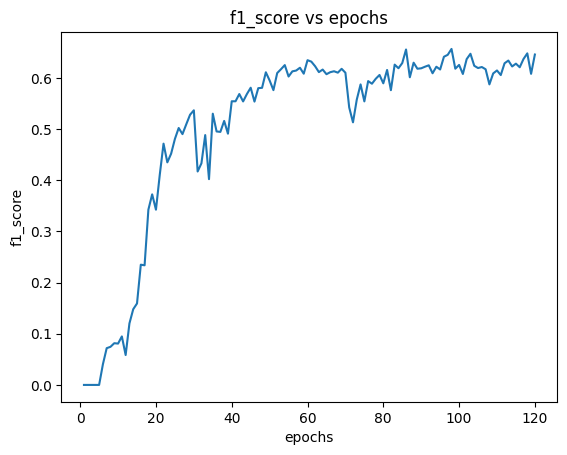

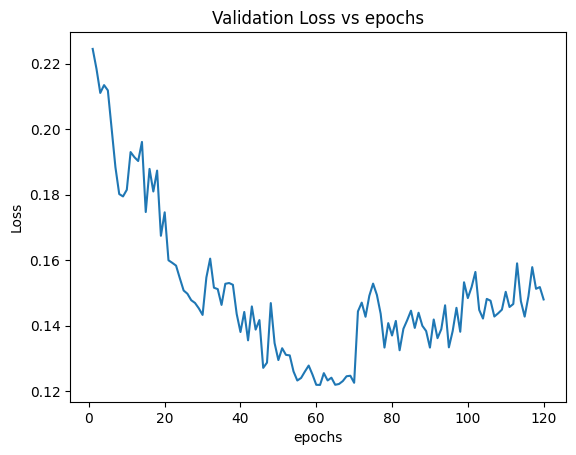

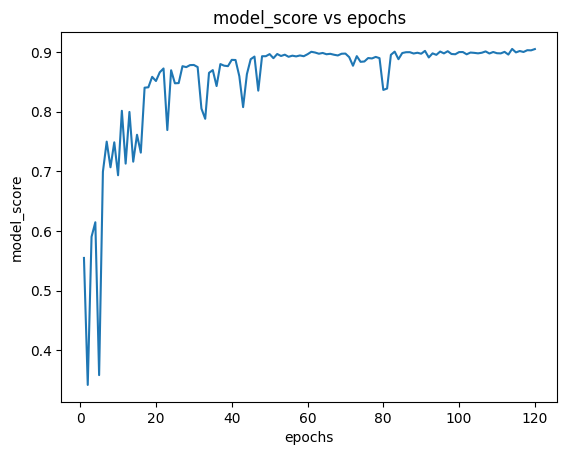

In [10]:
K= len(f1_arr) +1
plt.figure(1)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,K), f1_arr)
plt.xlabel("epochs")
plt.ylabel("f1_score")
plt.title('f1_score vs epochs')

plt.figure(2)
#plt.plot(sorted(list(set(roc_epochs))), loss_arr)
plt.plot(range(1,K), loss_arr)
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title('Validation Loss vs epochs')

plt.figure(3)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,K), model_arr)
plt.xlabel("epochs")
plt.ylabel("model_score")
plt.title('model_score vs epochs')

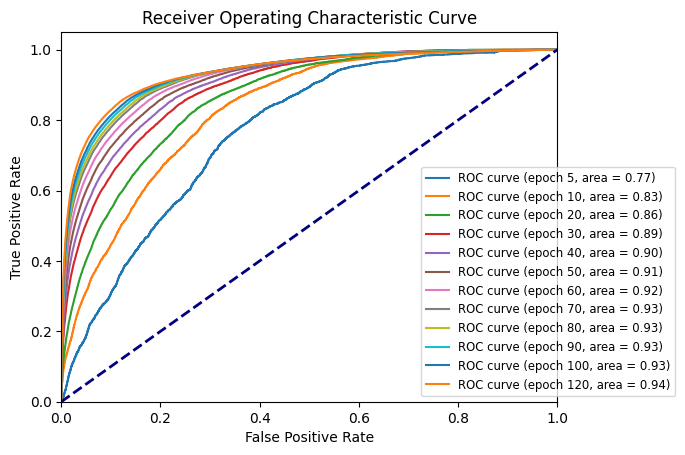

In [11]:
# plot ROC curve
fig2, ax2 = plt.subplots()
for i in range(len(roc_auc)):
    ax2.plot(roc_fpr[i], roc_tpr[i], label=f'ROC curve (epoch {roc_epochs[i]}, area = {roc_auc[i]:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver Operating Characteristic Curve')
# Set the properties for the legend
legend = ax2.legend(loc='lower right', bbox_to_anchor=(1.25, 0), fontsize='small', framealpha=0.8)